# InPowered Data Challenge
## Optimizing CPE across groups

### Problem Description
An advertising agency is trying to improve their delivery by decisioning on how much should they bid and budget on particular advertising items. These items are organized into campaign groups, and each item has a different targeting, creative (headline/summary), as well as a KPI outcome (cost per engagement, or CPE).

In order to improve their performance, the advertiser manager has given a sample of their historical performance to create an Machine Learning model that will predict the outcome (CPE) based on the targeting, creative, bids and budget variables.

### Variables Description
- Group - campaign group id
- Item - ID of the advertisement
- Channel - channel where the ad is running
- Date - date of the stats presented
- Bid - bid value that the advertiser is willing to pay to show the ad to the target audience
- Budget - budget value that the advertiser is willing to pay to show the ad to the target audience
- Engagements - # engagements did that add got for the whole day, given the current target audience, bids, and budgets
- Page_views -  # page views did that add got for the whole day, given the current target audience, bids, and budgets
- Clicks - # engagements did that add got for the whole day, given the current target audience, bids, and budgets
- Active_days - # days that ad item was active (counting present day)
- Media_spend - How much spend the ad item got in this day, given the bids and budgets
- Media_cpc  - ratio of media_spend and clicks
- CPE - company's main KPI, which is the ratio of media_spend / engagements. Ideally we should set this as low as we can
- Headline - the title of the ad item being shown to the users
- storySummary - the description of the ad item being shown to the users
- IABCategory - high-level category of the content being promoted
- targetGeo - target geolocation (ads will be shown in this geolocation)
- targetInterest - target interests (ads will be shown to users that have these interests)
- targetAge - target age (ads will be shown to user with this age)
- targetOs - target os (ads will be shown to users with this operating system)
- targetDevices - target devices (ads will be shown to users with these device types)
- targetGender - target gender (ads will be shown to users with this gender)
- targetLanguages - target languages (ads will be shown to users with this language)
- CATEGORY_1 - detailed category of the content being promoted

# Let's dive in this Challenge
#### Solution by Lais Alves

## Problem Understanding

First, it is important to understand the problem. The main goal posed by the advertised manager was to predict CPE based on certain advertising variables (bid, budget, targeting and creative). But what the advertised manager might really want is to minimize the main KPI, which is the CPE itself, to enhance the company's values, in other words, to maximize engagement.

It is a good approach to use historical data to understand and predict CPE based on various influencing factors. However, to make bidding and budget choices more effective, we can consider a different approach that not only predicts CPE but also optimizes bidding and budget decisions dynamically. This approach aims to minimize CPE or to maximize engagements, clicks, or other relevant metrics.

## Solution
In summary, my suggested approach is to:

(1) Prepare and Understand data;
- This includes preprocessing data and feature engineering (creation of interaction variables, such as budget/bids, or those between targeting and categories features; _Optionals_ - depends on features behaviour's complexity: time-delay embedding, to enhance model stability; and data embedding, such as PCA or t-SNE, to enhance visualization and model performance)
- Exploratory Data Analysis (EDA) to identify data behavior and relations betweens features (linearity/non-linearity, deterministic/stochastic nature, ergodicity/stationarity, possible segmentations to enhance predictions, etc.).

(2) Create a baseline ML model to predict CPE;
- This is like a MVP. The idea is to quickly create a ML model using standardized or automated approaches for feature selection, model training (hyperparameter tuning), and model evaluation.
- Building a predictive model to forecast the CPE based on historical data can help us understand which factors influence CPE the most and predict future CPE based on current scenarios (**Important Note**: If we start using this model to modify bidding, for example, the model may eventually become "descalibrated" on future data. Therefore, it is important to monitor its performance and define processes to update/retrain the model).

(3) (Optional, but highly recommended) Beat the baseline model:
- The ideia is to interactively go from "data & business understanding" to "modeling", and from "modeling" back to "data & business understanding" in order to cover the whole problem and end up with the best performing solution (This process is known as "CRISP-DM").
- The best performing models can be achieved through good feature engineering rather than model optimization/hyperparameter tunning (remember: "Garbage in, Garbaget out" -> good data is the most important when looking for performance improvements).

(4) (Optional, but also highly recommended, given the "hidden" goal to minimize CPE/maximize engagements) Create an optimization model:
- It is important to first define the objective function (for example, minimizing CPE or maximizing engagements, clicks or other relevant metrics), and the constraints, such as budget/bid limits and other business rules.
- The optimization solvers depend mainly on the variables types, constraints, and objective function. Therefore, it is important to understand data relationships in order to use the appropriate solver, which can be, for example, Linear or Mixed-Linear Programming, Heuristic or Metaheuristic Methods (such as Genetic Algorithms or Simulated Annealing), or Nonlinear Programming/Gradient-based Methods (such as the "common" Neural Networks training paradigm to inversely predict the inputs (big/budget, etc.) given the desired output (CPE), or Reinforcement Learning to dynamically adjust bids/budgets or other business variables to minimize the cumulative CPE over time).

Given my avaiable time, I will focus on data preprocessing, feature engineering, and EDA, to select an appropriate modeling approach to predict CPE using variables such as bid, budget, target features and the creatives (headline and summary). The generated insights and results can be considered a proof of concept (POC), which is fundamental in helping managers decide whether a data science project may recieve funding or not.

In [1]:
### Python Libraries Used ###

# Data manipulation
#%load_ext cudf.pandas # This accelerates pandas ecosystem using avaiable GPUs (more info at: https://rapids.ai/cudf-pandas/)
#from pandarallel import pandarallel # This is a simple and efficient tool to parallelize Pandas operations on all available CPUs.
import pandas as pd
import numpy as np

# Other libraries
import os
import re
import ast
import json
import pickle
from scipy.spatial.distance import cosine
from openai import OpenAI

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error

# Proprietary functions
from unique_insight import get_client, get_engagement_score, get_state

In [2]:
# This is important to know if we use CPU parallel processing
from multiprocessing import cpu_count
print(f"cpu_count: {cpu_count()}")

cpu_count: 12


In [3]:
# This is just to suppress unnescessary warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation and Understanding

In [4]:
# Load data
data = pd.read_csv('problem_merged_data.csv')
# (# rows, # columns)
data.shape

(1682, 24)

In [5]:
# Get a concise summary of the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   group            1682 non-null   int64  
 1   item             1682 non-null   int64  
 2   channel          1682 non-null   object 
 3   date             1682 non-null   object 
 4   bid              1682 non-null   float64
 5   budget           1682 non-null   float64
 6   engagements      1682 non-null   int64  
 7   page_views       1682 non-null   int64  
 8   clicks           1682 non-null   int64  
 9   active_days      1682 non-null   int64  
 10  media_spend      1682 non-null   float64
 11  media_cpc        1682 non-null   float64
 12  cpe              1682 non-null   float64
 13  headline         1682 non-null   object 
 14  storySummary     1682 non-null   object 
 15  IABCategory      1682 non-null   object 
 16  targetGeo        1682 non-null   object 
 17  targetInterest

In [6]:
# Display dataset's first 3 rows
pd.set_option('display.max_columns', None)
data.head(3)

group  item channel        date       bid       budget  engagements  \
0     37   997   YAHOO  2021-12-21  0.263696   660.923913          138   
1     37  1372   YAHOO  2021-12-21  0.263043   235.217391           80   
2     37  1372   YAHOO  2021-12-22  0.366809  1060.638298          251   

   page_views  clicks  active_days  media_spend  media_cpc       cpe  \
0         388     411            4       158.31       0.39  1.147174   
1         253     270            4        90.48       0.34  1.131000   
2         856     905            5       429.82       0.47  1.712430   

                                            headline  \
0  Get Valuable Discounts with AAA. Join for 50% Off   
1  Peace of Mind with AAA Roadside Service. Join Now   
2  Peace of Mind with AAA Roadside Service. Join Now   

                                        storySummary IABCategory  \
0  Peace of Mind with AAA Roadside Service. Join ...      Travel   
1  Peace of Mind with AAA Roadside Service. Join ...      Travel   
2  Peace of Mind with AAA Roadside Service. Join ...      Travel   

                                           targetGeo targetInterest targetAge  \
0  {"channelId":"YAHOO","channelName":"Yahoo","re...            NaN       NaN   
1  {"channelId":"YAHOO","channelName":"Yahoo","re...            NaN       NaN   
2  {"channelId":"YAHOO","channelName":"Yahoo","re...            NaN       NaN   

  targetOs targetDevices targetGender targetLanguages CATEGORY_1  
0      NaN           NaN          NaN             NaN        NaN  
1      NaN           NaN          NaN             NaN        NaN  
2      NaN           NaN          NaN             NaN        NaN

### Data Preprocessing

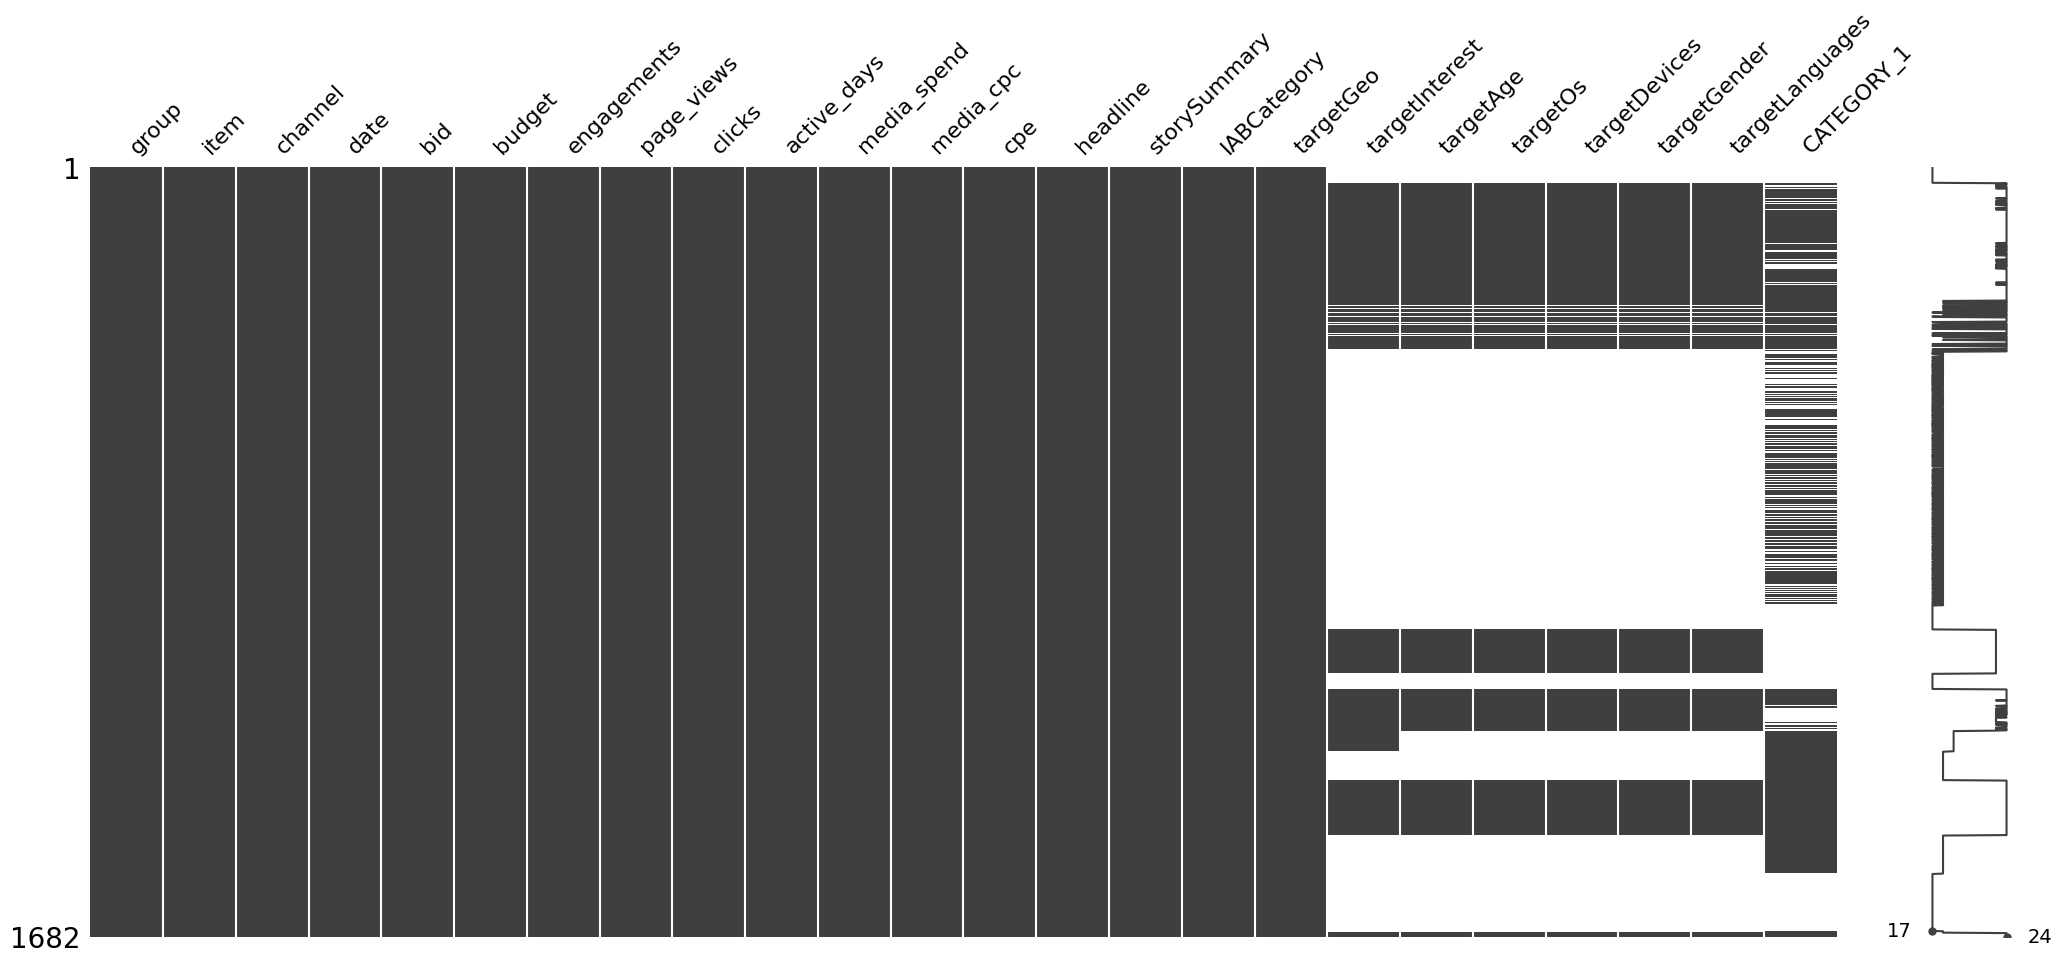

In [8]:
### Identifying missing values ###

# Visualize missing values using a matrix plot
msno.matrix(data)
plt.show()

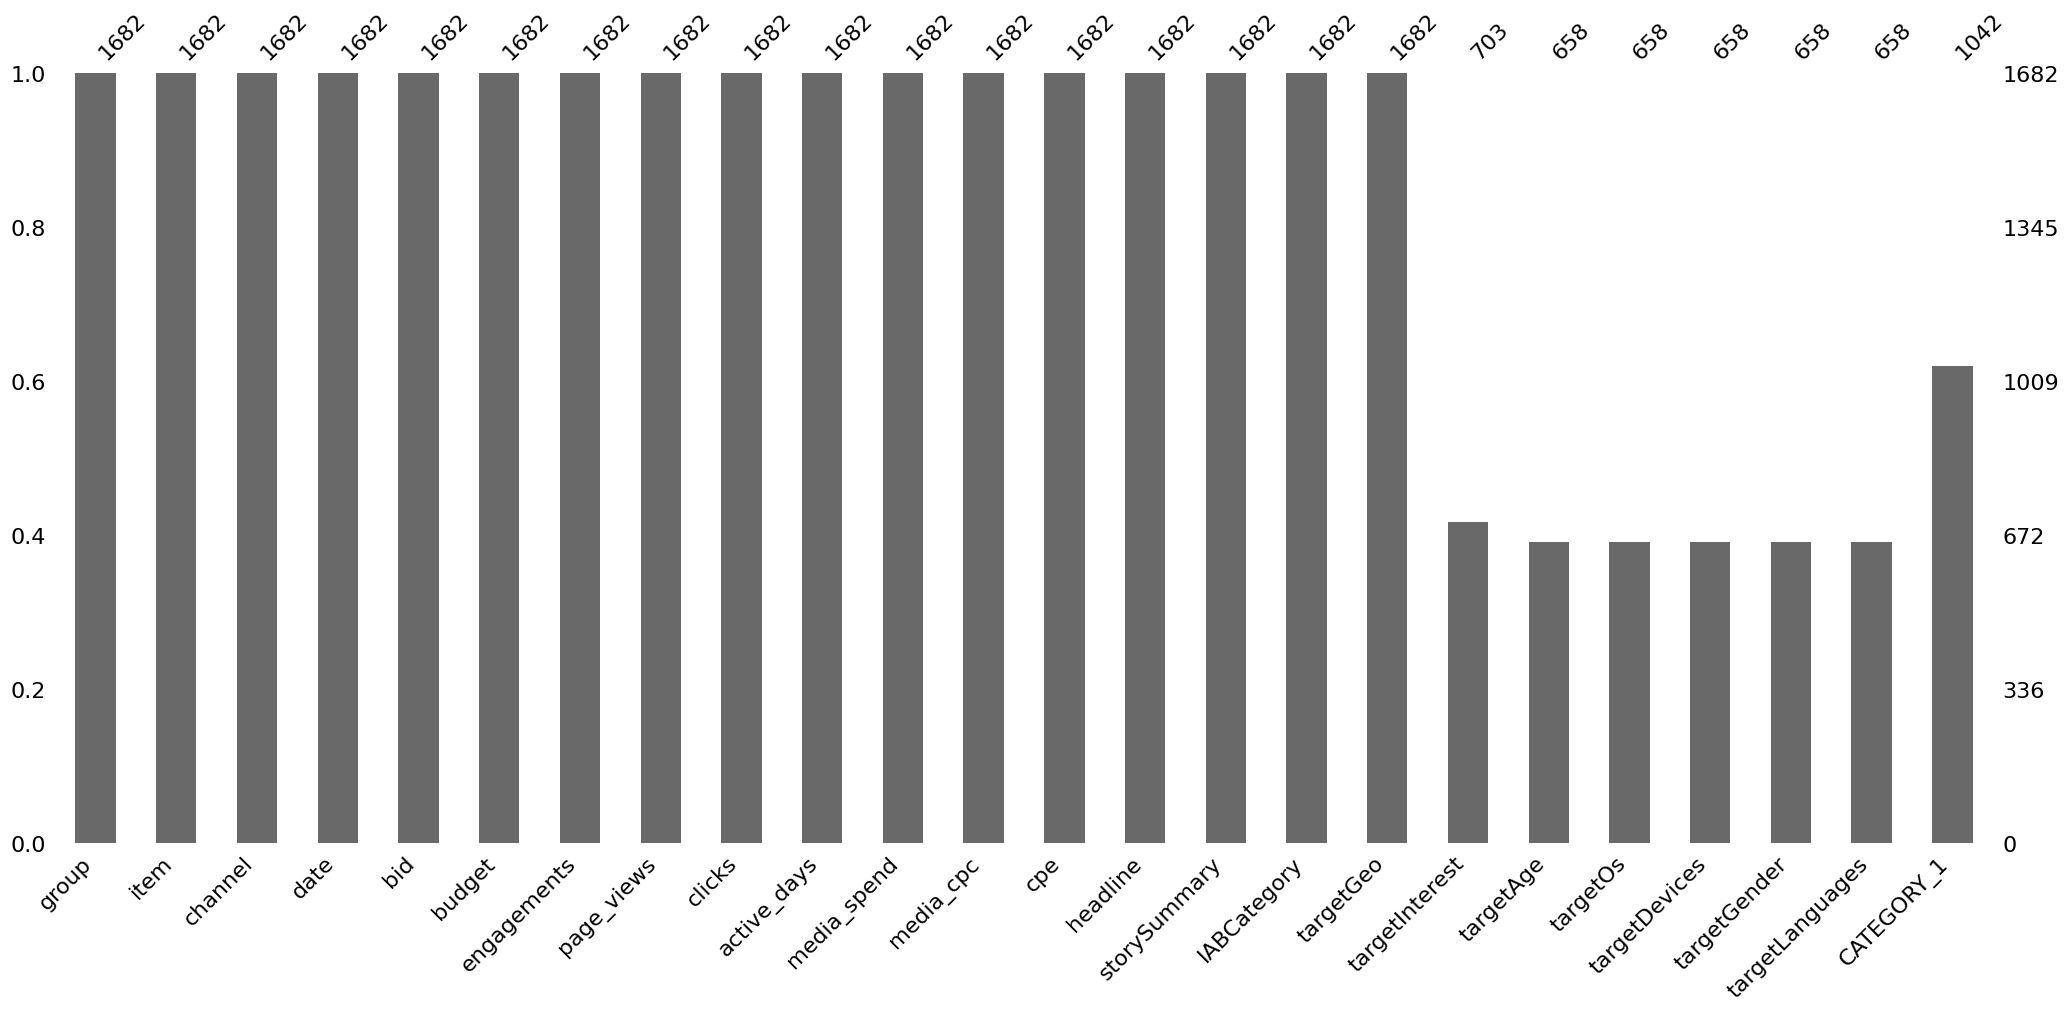

In [9]:
# Visualize missing values using a bar plot

# With this plot, it is possible to see that the target features will need a closer look. We need to fill these missing values with "something".
# We can have some glimpse and ideas just by looking this graphic, for example, it is possible to see that if we use some "category" variable
# to train our model, through one hot encoding, for example, it may not be necessary to join different features in order to enhance information,
# since `IABCategory` is all filled up.

msno.bar(data)
plt.show()

In [10]:
# Normalizing numerical features: Scale numerical features such as bids and budget to bring them to a similar range.

# NOTE: I am not performing normalization of numerical features, because I am going to use a tree based modeling approach (RandomForest, XGBoost, LGBM, etc.)
# This preprocessing step is required when we use scale sensitive models, particularly those that rely on distance measures or regularization, such as linear regression (with or without L1 or L2 regularizations), SVMs, or KNNs.

In [11]:
### Encoding categorical variables: Use of techniques like one-hot encoding or label encoding for targeting variables. ###

# We can use One Hot Encoding on categorical variables such as `targetGeo`, `targetInterest`, and `targetOs` 
# `targetLanguages` and `targetDevices` does not contain enough information to enhance model's prediction as they contains only one category. Therefore I will not use it during training, to avoid false correlations.
# One could thinto to process Age as a discrete variable, but depending on how Age is described/labeled, it may be more beneffitial to do Label encoding instead.

# Print unique values from targets
print("`targetAge` unique values: ", data['targetAge'].unique())
print("`targetOs` unique values: ", data['targetOs'].unique())
print("`targetGender` unique values: ", data['targetGender'].unique())
print("`targetLanguages` unique values: ", data['targetLanguages'].unique())
print("`targetDevices` unique values: ", data['targetDevices'].unique())

# Describes target features
data[['targetGeo', 'targetInterest', 'targetAge', 'targetOs', 'targetDevices', 'targetGender', 'targetLanguages']].describe()

`targetAge` unique values:  [nan '55-64;' '65+;' '35-44;' '45-54;']
`targetOs` unique values:  [nan 'IOS;' 'ANDROID;']
`targetGender` unique values:  [nan 'MALE;' 'FEMALE;']
`targetLanguages` unique values:  [nan 'en;']
`targetDevices` unique values:  [nan 'SMARTPHONES;']


targetGeo  \
count                                                1682   
unique                                                 16   
top     {"channelId":"REVCONTENT","geoType":"BUCKET","...   
freq                                                  581   

                                           targetInterest targetAge targetOs  \
count                                                 703       658      658   
unique                                                 24         4        2   
top     {"channelId":"YAHOO","channelName":"Yahoo","in...      65+;     IOS;   
freq                                                  132       393      490   

       targetDevices targetGender targetLanguages  
count            658          658             658  
unique             1            2               1  
top     SMARTPHONES;        MALE;             en;  
freq             658          535             658

In [12]:
# "Preprocessing" for `targetGeo` and `targetInterest` features

# Lets' transform these data to something useful...

# This function transforms a "dictionaries string" into a list of dictionaries
def get_target_dict(list_of_dict_str):

    try:
        obj_list = list_of_dict_str.split(';')

        dict_list = []
        for item in obj_list:
            if item:  # Check if the string is not empty
                dict_list.append(json.loads(item))
        return dict_list
    
    except:
        return list_of_dict_str # return original value if it is not in the "json input format"

# Columns to process
# Note: I've considered other variables as well, to show that the function could work if I had a setting with lots of different variables.
columns_to_convert = ['targetGeo', 'targetInterest', 'targetAge', 'targetOs', 'targetDevices', 'targetGender', 'targetLanguages'] 

# Creates new variables to store the processed targeting features
for col in columns_to_convert:
    data[f'{col}_temp'] = data[col].apply(lambda row: get_target_dict(row))

# Describe target features. Note that columns targetAge, targetOS, targetDevices, targetGender, and targetLanguages remains unchanged.
data[['targetGeo_temp', 'targetInterest_temp', 'targetAge_temp', 'targetOs_temp', 'targetDevices_temp', 'targetGender_temp', 'targetLanguages_temp']].describe()

targetGeo_temp  \
count                                                1682   
unique                                                 16   
top     [{'channelId': 'REVCONTENT', 'geoType': 'BUCKE...   
freq                                                  581   

                                      targetInterest_temp targetAge_temp  \
count                                                 703            658   
unique                                                 24              4   
top     [{'channelId': 'YAHOO', 'channelName': 'Yahoo'...           65+;   
freq                                                  132            393   

       targetOs_temp targetDevices_temp targetGender_temp targetLanguages_temp  
count            658                658               658                  658  
unique             2                  1                 2                    1  
top             IOS;       SMARTPHONES;             MALE;                  en;  
freq             490                658               535                  658

In [13]:
# Lets drop unnecessary columns and rename temporary columns
data = data.drop(columns=['targetGeo', 'targetInterest', 'targetLanguages', 'targetDevices', 'targetAge_temp', 'targetOs_temp', 'targetDevices_temp', 'targetGender_temp', 'targetLanguages_temp'])
data.rename(columns={'targetGeo_temp': 'targetGeo', 'targetInterest_temp': 'targetInterest'}, inplace=True)

In [14]:
### Transform targetGeo_temp and targetInterest_temp into usable features ###

# Show features details
data['targetGeo'][1000][1]
# data['targetInterest'][300]

{'channelId': 'YAHOO',
 'channelName': 'Yahoo',
 'cityId': '2495775',
 'cityName': 'Sonoma, CA',
 'regionId': '2347563',
 'regionName': 'California',
 'countryId': '23424977',
 'countryName': 'United States',
 'geoType': 'CITY',
 'hash': '1657829588',
 'exclusion': 'true'}

In [15]:
# This function extract features from the dictionaries
def extract_features(dict_list, key):
    try:
        feature_list = []
        for dict in range(len(dict_list)):
            if dict_list[dict][key] is None:
                pass
            else:
                feature_list.append(dict_list[dict][key])
        if feature_list == []:
            return None
        return feature_list
    except:
        return None

# We could extract all present features, but I will focus only on "usable"/"informative" ones

# features_targetGeo = ['channelId', 'channelName', 'cityId', 'cityName', 'regionId', 'regionName', 'countryId', 'countryName', 'geoType', 'bucketId', 'bucketName', 'bucketType', 'hash', 'exclusion']
features_targetGeo = ['cityName', 'regionName']

for feature in features_targetGeo:
    data[f'targetGeo_{feature}'] = data['targetGeo'].apply(lambda row: extract_features(row, feature))


# features_targetInterest = ['channelId', 'channelName', 'interestId', 'interestName', 'interestDescription', 'interestType']
features_targetInterest = ['interestName']

for feature in features_targetInterest:
    data[f'targetInterest_{feature}'] = data['targetInterest'].apply(lambda row: extract_features(row, feature))

In [16]:
data.head(2)

group  item channel        date       bid      budget  engagements  \
0     37   997   YAHOO  2021-12-21  0.263696  660.923913          138   
1     37  1372   YAHOO  2021-12-21  0.263043  235.217391           80   

   page_views  clicks  active_days  media_spend  media_cpc       cpe  \
0         388     411            4       158.31       0.39  1.147174   
1         253     270            4        90.48       0.34  1.131000   

                                            headline  \
0  Get Valuable Discounts with AAA. Join for 50% Off   
1  Peace of Mind with AAA Roadside Service. Join Now   

                                        storySummary IABCategory targetAge  \
0  Peace of Mind with AAA Roadside Service. Join ...      Travel       NaN   
1  Peace of Mind with AAA Roadside Service. Join ...      Travel       NaN   

  targetOs targetGender CATEGORY_1  \
0      NaN          NaN        NaN   
1      NaN          NaN        NaN   

                                           targetGeo targetInterest  \
0  [{'channelId': 'YAHOO', 'channelName': 'Yahoo'...            NaN   
1  [{'channelId': 'YAHOO', 'channelName': 'Yahoo'...            NaN   

  targetGeo_cityName                               targetGeo_regionName  \
0               None  [Baltimore, MD, Cincinnati, OH, Philadelphia, ...   
1               None  [Baltimore, MD, Cincinnati, OH, Philadelphia, ...   

  targetInterest_interestName  
0                        None  
1                        None

#### Why Avoid One-Hot Encoding with Many Categories

Although we may benefit from creating new features, sometimes it may hurt our model's performance'. One-hot encoding is a common technique for converting categorical variables into a numerical format that can be used by machine learning models. However, one-hot encoding can be problematic when dealing with categorical features that have a large number of unique categories because of problems such as High Dimensionality and Increase of Data Sparsity:

1. **High Dimensionality**: One-hot encoding creates a new binary feature for each category level. For example, if you have a categorical feature with 1000 unique categories, one-hot encoding will create 1000 new binary features. This explosion in the number of features can lead to the problems associated with high dimensionality discussed above.

2. **Sparsity**: One-hot encoded features are sparse, meaning most of the values are zeros. This sparsity can make it harder for certain machine learning algorithms to learn effectively.

#### Strategies to Deal with High Dimensionality
How to deal with these problems then? We can consider the following:
1. **Feature Selection**: Select only the most relevant features for the model. We can use techniques like Recursive Feature Elimination (RFE), LASSO (not Ridge) regression, and feature importance from tree-based methods can help in selecting important features.

2. **Dimensionality Reduction**: We can use techniques like Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), or Linear Discriminant Analysis (LDA) to reduce the number of features while preserving as much information as possible. The downside of these approaches is that we loose "direct" explainability.

3. **Encoding Strategies for Categorical Features**:
- Label Encoding: Assigns a unique integer to each category, but we should be cautious as this can introduce ordinal relationships that don’t exist.
- Target Encoding: Replaces each category with the mean of the target variable for that category.

4. **Clustering**: We could cluster similar categories together to reduce the number of unique categories before applying one-hot encoding or other encoding methods, or use NLP methodologies based on Large Language Models (LLMs) to process and reduce categories.

In [17]:
### Lets' analyze how many categories are in the new target variables created ###

# data['targetInterest_interestName'] unique values
# Convert the column to a list of lists
list_of_lists = data['targetInterest_interestName'].tolist()

# Flatten the list of lists
flattened_list = [item for sublist in list_of_lists if sublist is not None for item in sublist]

# Get unique values
unique_values = set(flattened_list)
print("# Categories in `targetInterest_interestName`: ", len(unique_values))
print(unique_values)

# Categories in `targetInterest_interestName`:  21
{'Travel [Verizon Media > Interest]', 'Computer processors [Verizon Media > Interest > Technology > Computers]', 'Small business [Verizon Media > Interest > Business and Industry]', 'Hypertension Propensity Caregivers - Reach Tier 2 [3rd Party Data > Adstra (ALC) > Syndicated > Caregivers > Caregivers by Condition Propensity by Type/Rx Use]', 'Computer servers [Verizon Media > Interest > Technology > Computers]', 'Fitness and wellness [Verizon Media > Interest]', 'Hypertension Propensity Caregivers - Reach Tier 1 [3rd Party Data > Adstra (ALC) > Syndicated > Caregivers > Caregivers by Condition Propensity by Type/Rx Use]', 'Business and Industry [Verizon Media > Interest]', 'Health care [Verizon Media > Interest > Business and Industry]', 'Retail [Verizon Media > Interest]', 'Network storage [Verizon Media > Interest > Technology > Computers]', 'Computers [Verizon Media > Interest > Technology]', 'Heart Disease [3rd Party Data > Livera

In [18]:
# Lets process `targetInterest_interestName`` to contain only the first words

def remove_square_brackets(text):
    if pd.isna(text):
        return None
    category = re.sub(r'\[.*?\]', '', text[0]).strip()
    return re.sub(r' - .*', '', category)

# Apply the function to the column
data['targetInterest_interestName_cleaned'] = data['targetInterest_interestName'].apply(remove_square_brackets)

# Display the cleaned DataFrame
print("# Categories in `targetInterest_interestName_cleaned`: ", len(data['targetInterest_interestName_cleaned'].unique()))
print(data['targetInterest_interestName_cleaned'].unique())

# Categories in `targetInterest_interestName_cleaned`:  19
[None 'Hypertension Propensity' 'Heart Disease'
 'Hypertension Propensity Caregivers' 'Travel' 'Computers' 'Technology'
 'B2B' 'Computer processors' 'Computer monitors' 'Network storage'
 'Computer servers' 'Business and Industry' 'Small business'
 'Small Business Owners' 'Insurance' 'Retail' 'Fitness and wellness'
 'Health care']


In [19]:
### data['targetGeo_regionName'] unique values ###

# Convert the column to a list of lists
list_of_lists = data['targetGeo_regionName'].tolist()

# Flatten the list of lists
flattened_list = [item for sublist in list_of_lists if sublist is not None for item in sublist]

# Get unique values
unique_values = set(flattened_list)
print("# Categories in `targetGeo_regionName`: ", len(unique_values))
print(unique_values)

# Categories in `targetGeo_regionName`:  59
{'Baltimore, MD', 'Washington, DC (Hagerstown), MD', 'San Francisco-Oakland-San Jose, CA', 'Illinois', 'Louisiana', 'Monterey-Salinas, CA', 'Los Angeles, CA', 'Montana', 'Iowa', 'Bakersfield, CA', 'Michigan', 'Dallas-Ft. Worth, TX', 'Vermont', 'Georgia', 'Cincinnati, OH', 'Las Vegas, NV', 'Denver, CO', 'Reno, NV', 'Texas', 'Wisconsin', 'California', 'Maine', 'Arkansas', 'South Dakota', 'Mississippi', 'Portland, OR', 'Missouri', 'Wyoming', 'Ohio', 'Nevada', 'San Diego, CA', 'Utah', 'Philadelphia, PA', 'Seattle-Tacoma, WA', 'Santa Barbara-Santa Maria-San Luis Obispo, CA', 'Arizona', 'North Dakota', 'Alabama', 'Virginia', 'North Carolina', 'Indiana', 'New Mexico', 'Phoenix, AZ', 'Eureka, CA', 'Kansas', 'Nebraska', 'Oklahoma', 'Medford-Klamath Falls, OR', 'Idaho', 'Sacramento-Stockton-Modesto, CA', 'Pennsylvania', 'Colorado', 'New Hampshire', 'Chico-Redding, CA', 'Fresno-Visalia, CA', 'Oregon', 'Kentucky', 'Tennessee', 'Minnesota'}


In [20]:
# Let's map each item inside the unique_values list to its corresponding state name.
# I used GPT-4o to create a dictionary that maps these unique values to states.
# Dictionary mapping locations to state names

location_to_state = {
    'Montana': 'MT', 'Utah': 'UT', 'Vermont': 'VT', 'Georgia': 'GA', 'Wyoming': 'WY',
    'Phoenix, AZ': 'AZ', 'Oregon': 'OR', 'Missouri': 'MO', 'Oklahoma': 'OK', 'Maine': 'ME',
    'Reno, NV': 'NV', 'Iowa': 'IA', 'Dallas-Ft. Worth, TX': 'TX', 'Louisiana': 'LA',
    'Bakersfield, CA': 'CA', 'Arizona': 'AZ', 'Nevada': 'NV', 'Tennessee': 'TN',
    'Seattle-Tacoma, WA': 'WA', 'Santa Barbara-Santa Maria-San Luis Obispo, CA': 'CA',
    'Wisconsin': 'WI', 'Alabama': 'AL', 'Idaho': 'ID', 'Arkansas': 'AR', 'Mississippi': 'MS',
    'North Carolina': 'NC', 'San Diego, CA': 'CA', 'Indiana': 'IN', 'Michigan': 'MI',
    'Texas': 'TX', 'Virginia': 'VA', 'Eureka, CA': 'CA', 'Ohio': 'OH', 'California': 'CA',
    'Medford-Klamath Falls, OR': 'OR', 'South Dakota': 'SD', 'Philadelphia, PA': 'PA',
    'Washington, DC (Hagerstown), MD': 'DC/MD', 'Cincinnati, OH': 'OH', 'North Dakota': 'ND',
    'Fresno-Visalia, CA': 'CA', 'Colorado': 'CO', 'Nebraska': 'NE', 'Denver, CO': 'CO',
    'Chico-Redding, CA': 'CA', 'Kentucky': 'KY', 'Illinois': 'IL', 'Los Angeles, CA': 'CA',
    'Minnesota': 'MN', 'New Hampshire': 'NH', 'Monterey-Salinas, CA': 'CA', 'Las Vegas, NV': 'NV',
    'Kansas': 'KS', 'Baltimore, MD': 'MD', 'Pennsylvania': 'PA', 'New Mexico': 'NM',
    'San Francisco-Oakland-San Jose, CA': 'CA', 'Sacramento-Stockton-Modesto, CA': 'CA',
    'Portland, OR': 'OR'
}

# Function to map locations to state names
def map_to_state(location_list):
    if location_list is None:
        return None
    return [location_to_state.get(location, location) for location in location_list]

# Apply the mapping function to the DataFrame column
data['targetGeo_regionName_cleaned'] = data['targetGeo_regionName'].apply(map_to_state)


In [21]:
data['targetGeo_regionName_cleaned']

0       [MD, OH, PA, DC/MD]
1       [MD, OH, PA, DC/MD]
2       [MD, OH, PA, DC/MD]
3       [MD, OH, PA, DC/MD]
4       [MD, OH, PA, DC/MD]
               ...         
1677                   None
1678                   None
1679                   None
1680                   None
1681                   None
Name: targetGeo_regionName_cleaned, Length: 1682, dtype: object

In [22]:
### data['targetGeo_regionName_cleaned'] unique values ###

# With this technique, I was able to reduce from 59 to 40 region categories.

# Convert the column to a list of lists
list_of_lists = data['targetGeo_regionName_cleaned'].tolist()

# Flatten the list of lists
flattened_list = [item for sublist in list_of_lists if sublist is not None for item in sublist]

# Get unique values
unique_values = set(flattened_list)
print("# Categories in `targetGeo_regionName_cleaned`: ", len(unique_values))
print(unique_values)

# Categories in `targetGeo_regionName_cleaned`:  40
{'MO', 'NH', 'IN', 'MT', 'NM', 'OR', 'CO', 'NV', 'UT', 'NE', 'TX', 'ND', 'MI', 'IL', 'CA', 'OH', 'ME', 'GA', 'KY', 'AR', 'WI', 'VT', 'VA', 'LA', 'MD', 'WY', 'MS', 'WA', 'TN', 'ID', 'NC', 'SD', 'DC/MD', 'KS', 'AZ', 'IA', 'AL', 'OK', 'MN', 'PA'}


### Feature Engineering

In [23]:
### Processing of Text features: We can use NLP techniques like TF-IDF or word embeddings to convert text features (headline, summary, etc.) into numerical features. ###

# I will focus on the creation of new features by looking on similarity scores between targetInterests and the creatives, using OpenAI embeddings
# Note: If we used TF-IDF instead, we should be aware on "when" to apply it to generate new features. 
# Ideally, we should have to use it after the train/test/split to avoid "time poisoning", when we "insert" future data in the training and test sets.
# By using embeddings, we do not have this problem, since it is "row independent", it does not depends on the entire dataset structure 
# (differently from TF-IDFs models, which depends on all 'documents' frequency). 

# Join headline and storySummary into one feature
data['creative'] = data['headline'] + ": " + data['storySummary']

In [24]:
# This is an example on how to calculate similarity scores using OpenAI Embedding model

client = get_client()

def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def cosine_similarity(a, b):
    return 1 - cosine(a, b)

df = pd.DataFrame({
    'text1': [
        "O rei e a rainha de Calcutá.", "O rei e a rainha de Calcutá."
    ],
    'text2': [
        "A rainha de Calcutá está feliz.", "A lua está cheia e o astronauta olha feliz para ela."
    ]
})

df['text1_emb'] = df['text1'].apply(lambda x: get_embedding(x))
df['text2_emb'] = df['text2'].apply(lambda x: get_embedding(x))
df['similarity'] = df.apply(lambda row: cosine_similarity(row['text1_emb'], row['text2_emb']), axis=1)

df

text1  \
0  O rei e a rainha de Calcutá.   
1  O rei e a rainha de Calcutá.   

                                               text2  \
0                    A rainha de Calcutá está feliz.   
1  A lua está cheia e o astronauta olha feliz par...   

                                           text1_emb  \
0  [0.040591686964035034, -0.02302762307226658, 0...   
1  [0.04052568972110748, -0.023013457655906677, 0...   

                                           text2_emb  similarity  
0  [0.05863206833600998, -0.011446141637861729, 0...    0.731926  
1  [0.0017401024233549833, 0.017766939476132393, ...    0.191508

In [25]:
# Save dataframe
# data.to_csv('problem_merged_data_with_similarity_scr.csv', index=False)

# Load data
data = pd.read_csv('problem_merged_data_with_similarity_scr.csv')

In [26]:
### Interaction terms: Create features that capture interactions between bids and budget, or between targeting and creative. ###

# Log(bid)
data['log_bid'] = np.log(data['bid'])

# budget / bid
data['budget_bid'] = data['budget'] / data['bid']

In [27]:
### Binning: Transform variables into categorical features using binning and check for model improvement. ###

# Binning of the `bid` variable
data['bid_bins'] = pd.cut(data['bid'], bins=2, labels=["Low", "High"])

In [28]:
### Creation of new features using gpt-4o capabilities ###

# Get an OpenAI API key
openai_client = get_client()

# I have created a function that calls OpenAI API. This function creates a "Marketing Agent" that calculates "engagement" scores based on headlines and summary texts.
# This funtion uses a prompt, that I have engineered myself, send it to GPT-4o togheter with the headline and summary texts,
# and it returns a `json` file, containing the headline, the summary, and the engagement score.
#
# I won't use it for the baseline modelling, but this could be a beneficial tool to enhance information about the impact of good/bad writing creatives on CPE.
#  
# Example on how this function works
get_engagement_score(openai_client, 
                     headline="Access Our AFib Guide",
                     summary="Access Cleveland Clinic's free Afib guide to learn about treatment options from the nation's #1 heart program. Get answers today.")


{'headline': 'Access Our AFib Guide',
 'summary': "Access Cleveland Clinic's free Afib guide to learn about treatment options from the nation's #1 heart program. Get answers today.",
 'engagement_score': '85'}

## Data Understanding

In [29]:
# Group representation
group_counts = data[['group']].groupby('group').value_counts()
group_percentages = (group_counts/data.shape[0]) * 100

group_df = pd.DataFrame({
    'absolute_values': group_counts,
    'percentages': group_percentages
}).reset_index()

print(group_df)

   group  absolute_values  percentages
0     37               35     2.080856
1     45              922    54.815696
2     50              183    10.879905
3     53              136     8.085612
4     57              267    15.873960
5     64                4     0.237812
6     65               93     5.529132
7     66                3     0.178359
8     75               25     1.486326
9     83               14     0.832342


In [30]:
# IABCategory representation in %
print("IABCategory representation in %:")
print((data[['IABCategory']].groupby('IABCategory').value_counts()/data.shape[0])*100)
print()
print("IABCategory representation in % (without group 45):")
print((data[data['group'] != 45].groupby('IABCategory')['IABCategory'].value_counts()/data[data['group'] != 45].shape[0])*100)

IABCategory representation in %:
IABCategory
Business and Finance    29.726516
Medical Health          55.885850
News and Politics        1.486326
Travel                  12.901308
Name: count, dtype: float64

IABCategory representation in % (without group 45):
IABCategory
Business and Finance    65.789474
Medical Health           2.368421
News and Politics        3.289474
Travel                  28.552632
Name: count, dtype: float64


In [31]:
### Understanding the distribution of the target variable (CPE) and Summary Statistics ###

# This helps to understand the central tendency and variability.

print(data['cpe'].describe())

count    1682.000000
mean        1.340462
std         0.851172
min         0.104409
25%         0.832027
50%         1.111765
75%         1.653750
max         7.547500
Name: cpe, dtype: float64


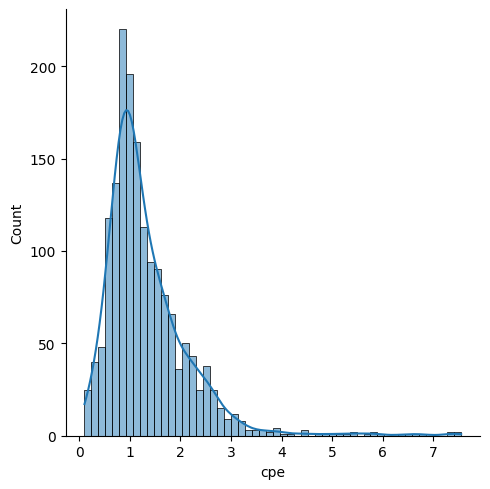

In [32]:
sns.displot(data=data, x='cpe', kde=True, palette='dark')

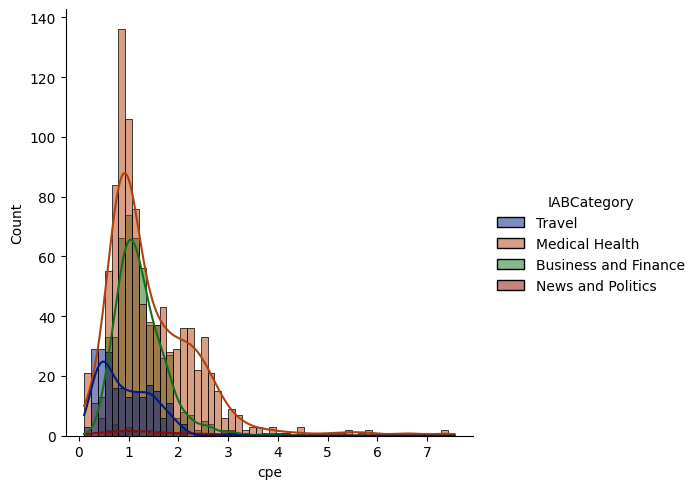

In [33]:
# It may be beneffitial to use IABCategory via One Hot Encoding, in that way we "force" tree based models to see these data as "separate ones",
# just in the way we are visualizing in this following graph.

sns.displot(data=data, x='cpe', kde=True, hue='IABCategory', palette='dark')

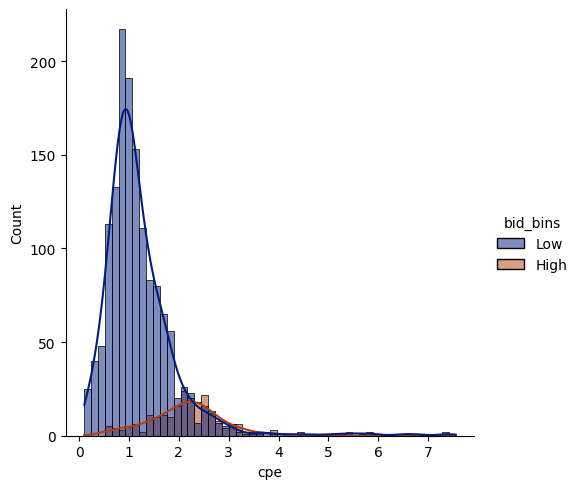

In [34]:
# Binning of the `bid` variable
# data['bid_bins'] = pd.cut(data['bid'], bins=2, labels=["Low", "High"])
sns.displot(data=data, x='cpe', kde=True, hue='bid_bins', palette='dark')

In [35]:
print(data.groupby(by='bid_bins')['bid'].max())

bid_bins
Low     0.629787
High    1.170000
Name: bid, dtype: float64


In [36]:
data.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'CATEGORY_1', 'targetGeo', 'targetInterest',
       'targetGeo_cityName', 'targetGeo_regionName',
       'targetInterest_interestName', 'targetInterest_interestName_cleaned',
       'targetGeo_regionName_cleaned', 'creative', 'similarity_score',
       'log_bid', 'budget_bid', 'bid_bins'],
      dtype='object')

In [37]:
data[['IABCategory', 'group']].drop_duplicates().sort_values(by='IABCategory').reset_index(drop=True)

IABCategory  group
0   Business and Finance     50
1   Business and Finance     53
2   Business and Finance     57
3   Business and Finance     65
4   Business and Finance     66
5         Medical Health     45
6         Medical Health     64
7         Medical Health     83
8      News and Politics     75
9                 Travel     37
10                Travel     50

In [38]:
data[['IABCategory', 'group', 'CATEGORY_1']].drop_duplicates().sort_values(by='IABCategory').reset_index(drop=True)

IABCategory  group  \
0   Business and Finance     57   
1   Business and Finance     66   
2   Business and Finance     65   
3   Business and Finance     50   
4   Business and Finance     53   
5   Business and Finance     53   
6   Business and Finance     53   
7   Business and Finance     57   
8   Business and Finance     57   
9   Business and Finance     57   
10        Medical Health     64   
11        Medical Health     83   
12        Medical Health     45   
13        Medical Health     45   
14        Medical Health     83   
15     News and Politics     75   
16                Travel     50   
17                Travel     37   

                                           CATEGORY_1  
0                                  /Finance/Insurance  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4          /Computers & Electronics/Computer Security  
5                              /Business & Industrial  
6                                                 NaN  
7                              /Business & Industrial  
8      /Autos & Vehicles/Vehicle Codes & Driving Laws  
9   /Business & Industrial/Construction & Maintenance  
10                                                NaN  
11                          /Health/Health Conditions  
12                                                NaN  
13                          /Health/Health Conditions  
14                             /Health/Women's Health  
15                                                NaN  
16                                                NaN  
17                                                NaN

In [39]:
# CPE means for each IABCategory
data.groupby('group')['cpe'].mean().sort_values()

group
83    0.609711
50    0.853839
53    1.111331
57    1.141449
37    1.326043
45    1.485789
75    1.598565
66    1.718035
65    1.742528
64    2.619732
Name: cpe, dtype: float64

In [40]:
# CPE means for each IABCategory
data.groupby('IABCategory')['cpe'].mean().sort_values()

IABCategory
Travel                  0.929728
Business and Finance    1.248060
Medical Health          1.477566
News and Politics       1.598565
Name: cpe, dtype: float64

In [41]:
# CPE means for each IABCategory
data.groupby('CATEGORY_1')['cpe'].mean().sort_values()

CATEGORY_1
/Health/Women's Health                               0.628034
/Business & Industrial                               0.886975
/Computers & Electronics/Computer Security           1.215555
/Autos & Vehicles/Vehicle Codes & Driving Laws       1.225289
/Business & Industrial/Construction & Maintenance    1.351297
/Finance/Insurance                                   1.396245
/Health/Health Conditions                            1.500193
Name: cpe, dtype: float64

In [42]:
# As we will see in the following boxplots and time series graphics, group 45 behave differently and have a meaninful impact on the dataset.
# This group's data should be used with caution during model training.

# It may not be exactly outliers because of its representative size (> 50% of the dataset); therefore, it is of extreme importance to understand their behavior and how they came to be.

mask = data['group'].isin([45])
data[mask]

group  item     channel        date       bid      budget  engagements  \
35      45  1805       YAHOO  2022-01-10  0.099762    7.023810           95   
36      45  1805       YAHOO  2022-01-10  0.099762    7.023810           95   
37      45   750       YAHOO  2022-01-11  0.219149   11.595745           72   
38      45  1805       YAHOO  2022-01-12  0.109574  100.000000           22   
39      45  1114       YAHOO  2022-01-12  0.318085   83.723404           35   
..     ...   ...         ...         ...       ...         ...          ...   
952     45  1716  REVCONTENT  2022-12-31  0.600000  100.000000           46   
953     45  1314  REVCONTENT  2022-12-31  0.600000  200.000000           47   
954     45  1016  REVCONTENT  2022-12-31  0.600000  100.000000           27   
955     45    48  REVCONTENT  2022-12-31  0.600000  100.000000           42   
956     45  1817  REVCONTENT  2022-12-31  0.600000  100.000000           21   

     page_views  clicks  active_days  media_spend  media_cpc       cpe  \
35          268     314            1        10.02       0.03  0.105474   
36          268     314            2        10.02       0.03  0.105474   
37          155     175            1        19.30       0.11  0.268056   
38           71      88            4         2.49       0.03  0.113182   
39           55      63            1         5.67       0.09  0.162000   
..          ...     ...          ...          ...        ...       ...   
952         154     184          177        91.20       0.50  1.982609   
953         527     539          176       315.60       0.59  6.714894   
954          69      82          178        42.60       0.52  1.577778   
955         156     171          178        96.00       0.56  2.285714   
956          72      98          199        52.80       0.54  2.514286   

                                        headline  \
35                         Access Our AFib Guide   
36                         Access Our AFib Guide   
37   Get a Second Opinion from the Nation's Best   
38                         Access Our AFib Guide   
39   Get a Second Opinion from the Nation's Best   
..                                           ...   
952  Get a Second Opinion from the Nation's Best   
953                    Free AFib Treatment Guide   
954                        Access Our AFib Guide   
955  Get a Second Opinion from the Nation's Best   
956                    Free AFib Treatment Guide   

                                          storySummary     IABCategory  \
35   Access Cleveland Clinic's free Afib guide to l...  Medical Health   
36   Access Cleveland Clinic's free Afib guide to l...  Medical Health   
37   Cleveland Clinic, a non-profit academic medica...  Medical Health   
38   Access Cleveland Clinic's free Afib guide to l...  Medical Health   
39   Cleveland Clinic, a non-profit academic medica...  Medical Health   
..                                                 ...             ...   
952  Cleveland Clinic, a non-profit academic medica...  Medical Health   
953  Access Cleveland Clinic's free Afib guide to l...  Medical Health   
954  Access Cleveland Clinic's free Afib guide to l...  Medical Health   
955  Cleveland Clinic, a non-profit academic medica...  Medical Health   
956  Access Cleveland Clinic's free Afib guide to l...  Medical Health   

    targetAge targetOs targetGender                 CATEGORY_1  \
35     55-64;     IOS;        MALE;  /Health/Health Conditions   
36     55-64;     IOS;        MALE;  /Health/Health Conditions   
37     55-64;     IOS;        MALE;                        NaN   
38     55-64;     IOS;        MALE;  /Health/Health Conditions   
39       65+;     IOS;        MALE;                        NaN   
..        ...      ...          ...                        ...   
952       NaN      NaN          NaN                        NaN   
953       NaN      NaN          NaN  /Health/Health Conditions   
954       NaN      NaN          NaN  /Health/Health Conditi

### Pair plots

Lets' visualize how features relates among each other.

Pair plots can be used to visualize all the relationship between numerical features and the target variable.

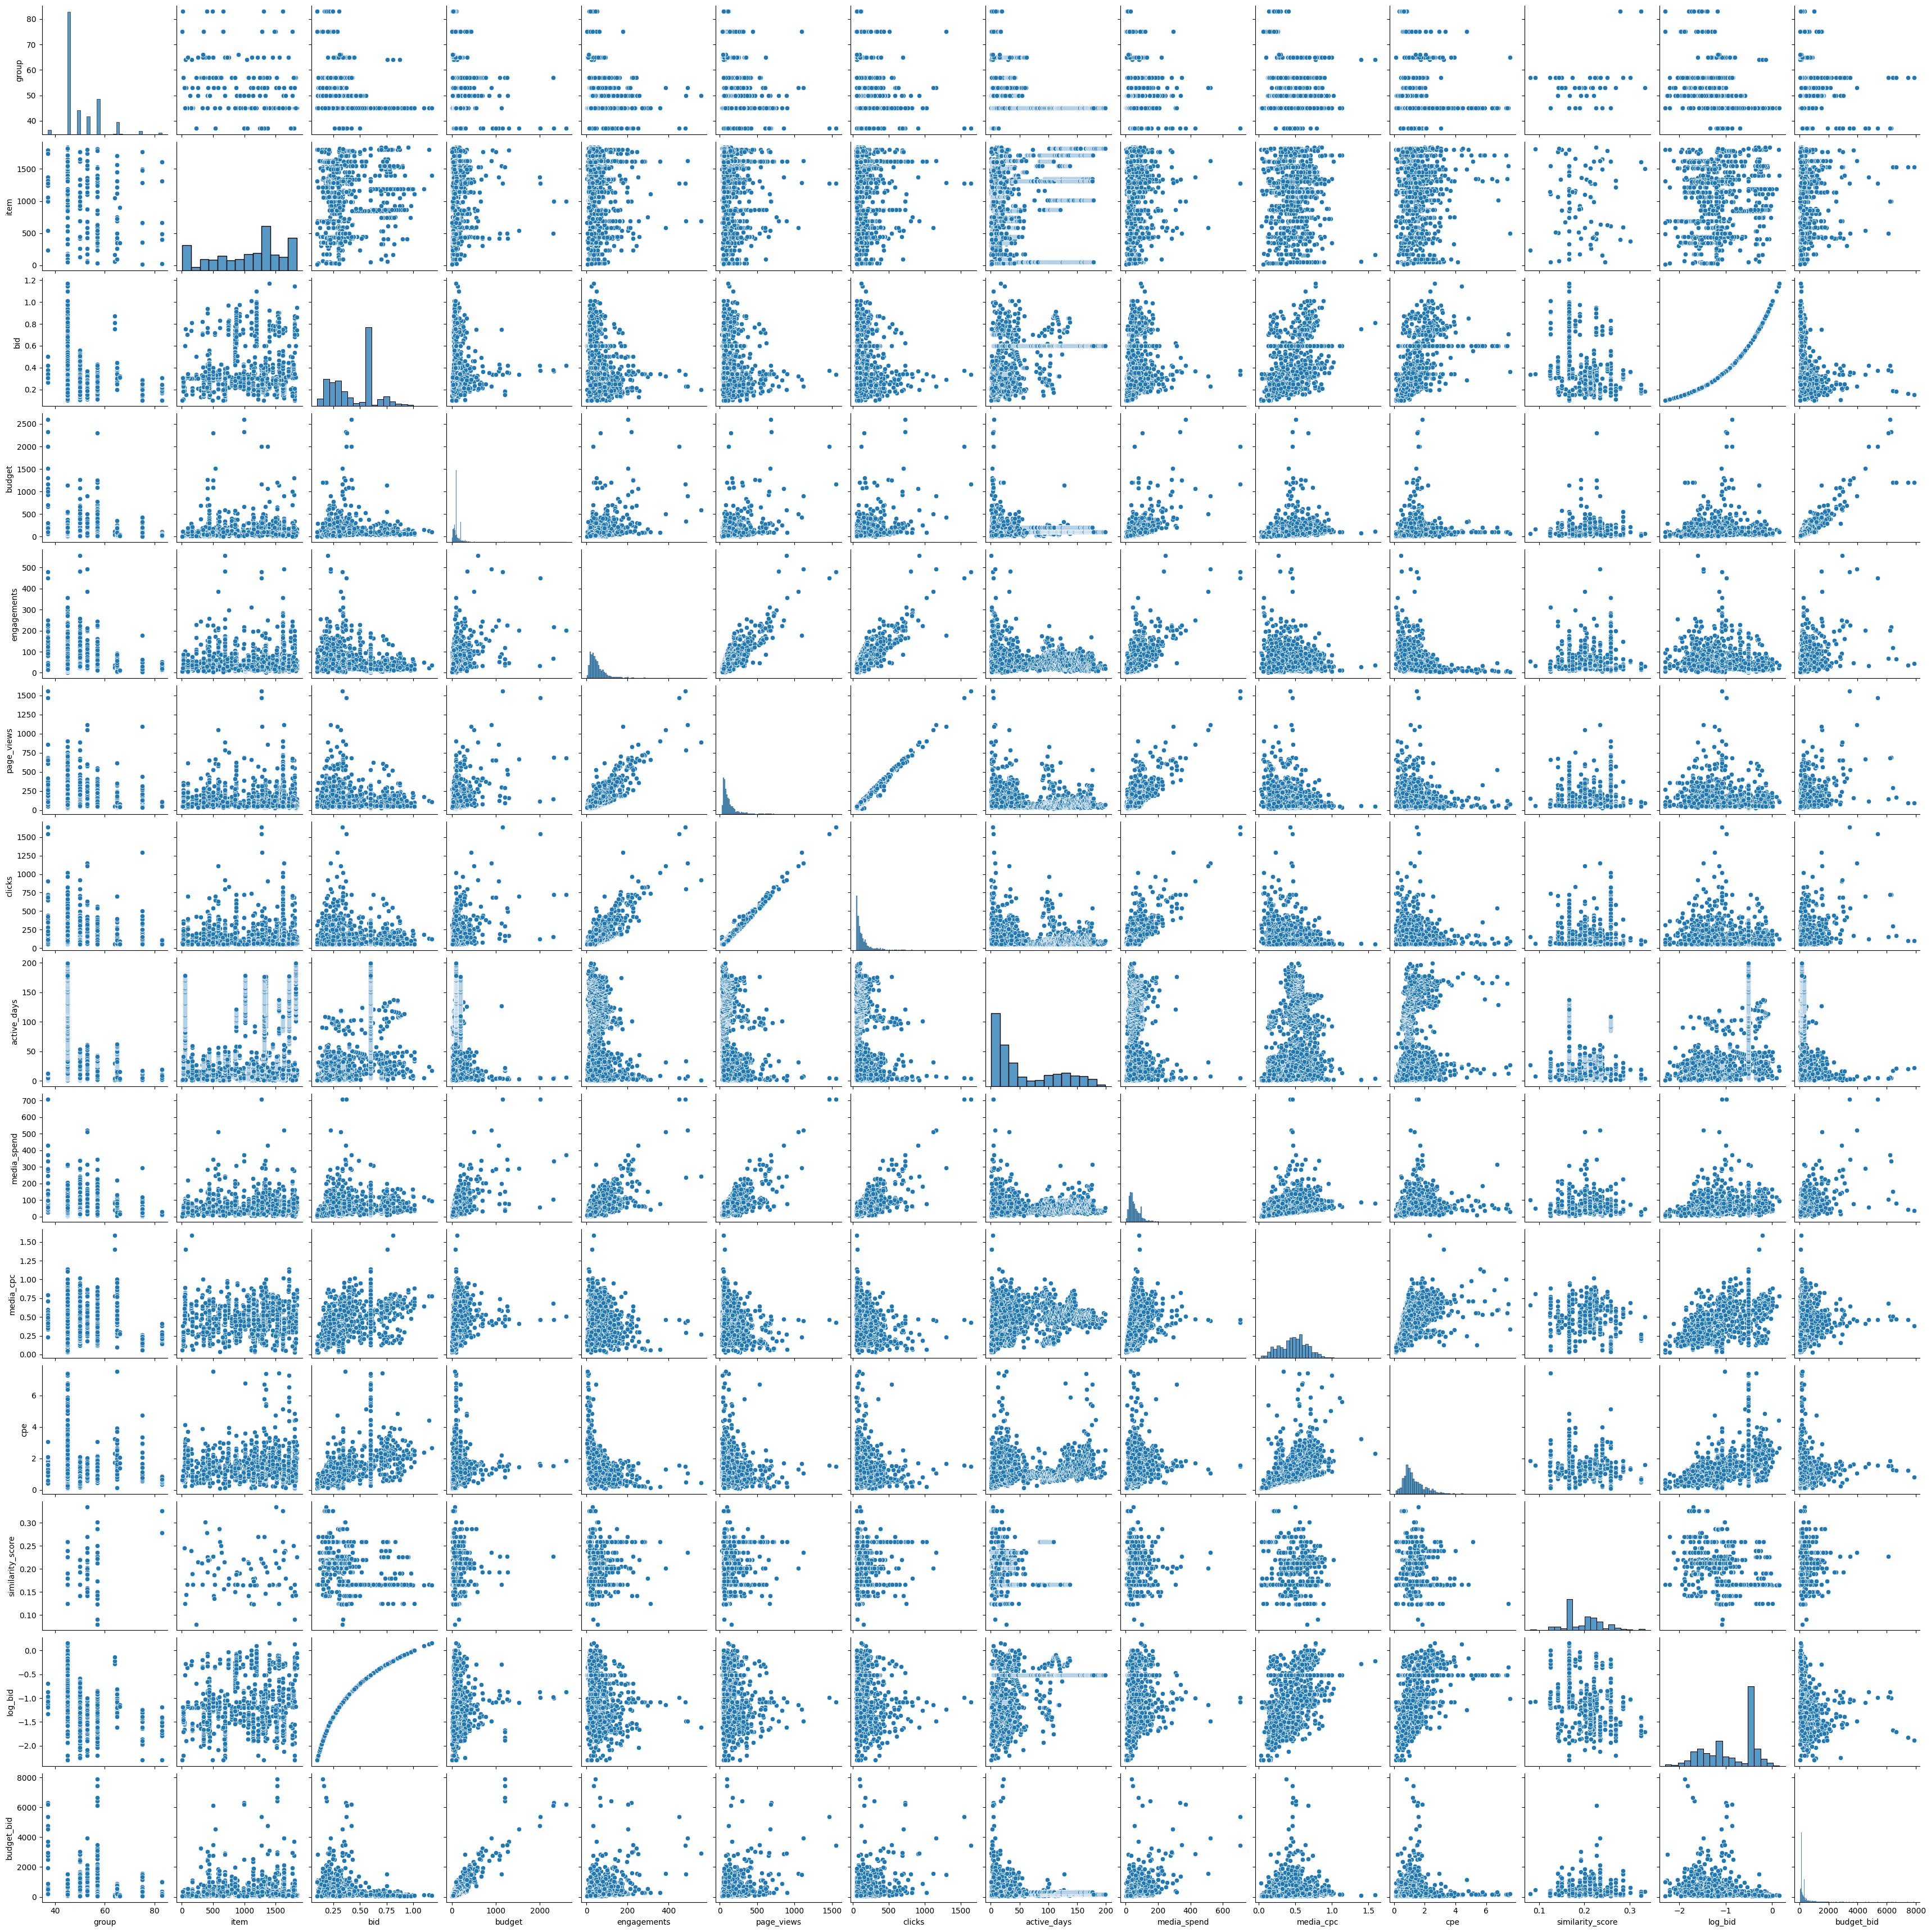

In [43]:
### Exploring relationships between features and the target variable (CPE). ###

# Pair plots data
sns.pairplot(data)

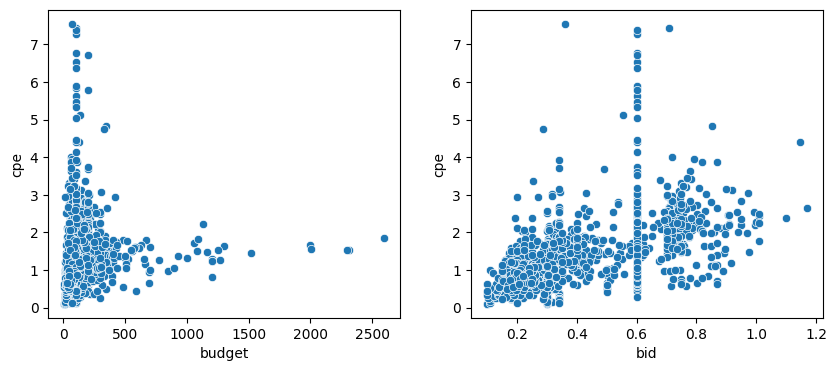

In [44]:
# Scatter Plots
# To visualize the relationship between numerical features and the target variable.
# This helps to see if there are any linear or non-linear relationships.

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Create plots using Seaborn
sns.scatterplot(x='budget', y='cpe', data=data, ax=axes[0])
sns.scatterplot(x='bid', y='cpe', data=data, ax=axes[1])
plt.show()

In [45]:
data.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'CATEGORY_1', 'targetGeo', 'targetInterest',
       'targetGeo_cityName', 'targetGeo_regionName',
       'targetInterest_interestName', 'targetInterest_interestName_cleaned',
       'targetGeo_regionName_cleaned', 'creative', 'similarity_score',
       'log_bid', 'budget_bid', 'bid_bins'],
      dtype='object')

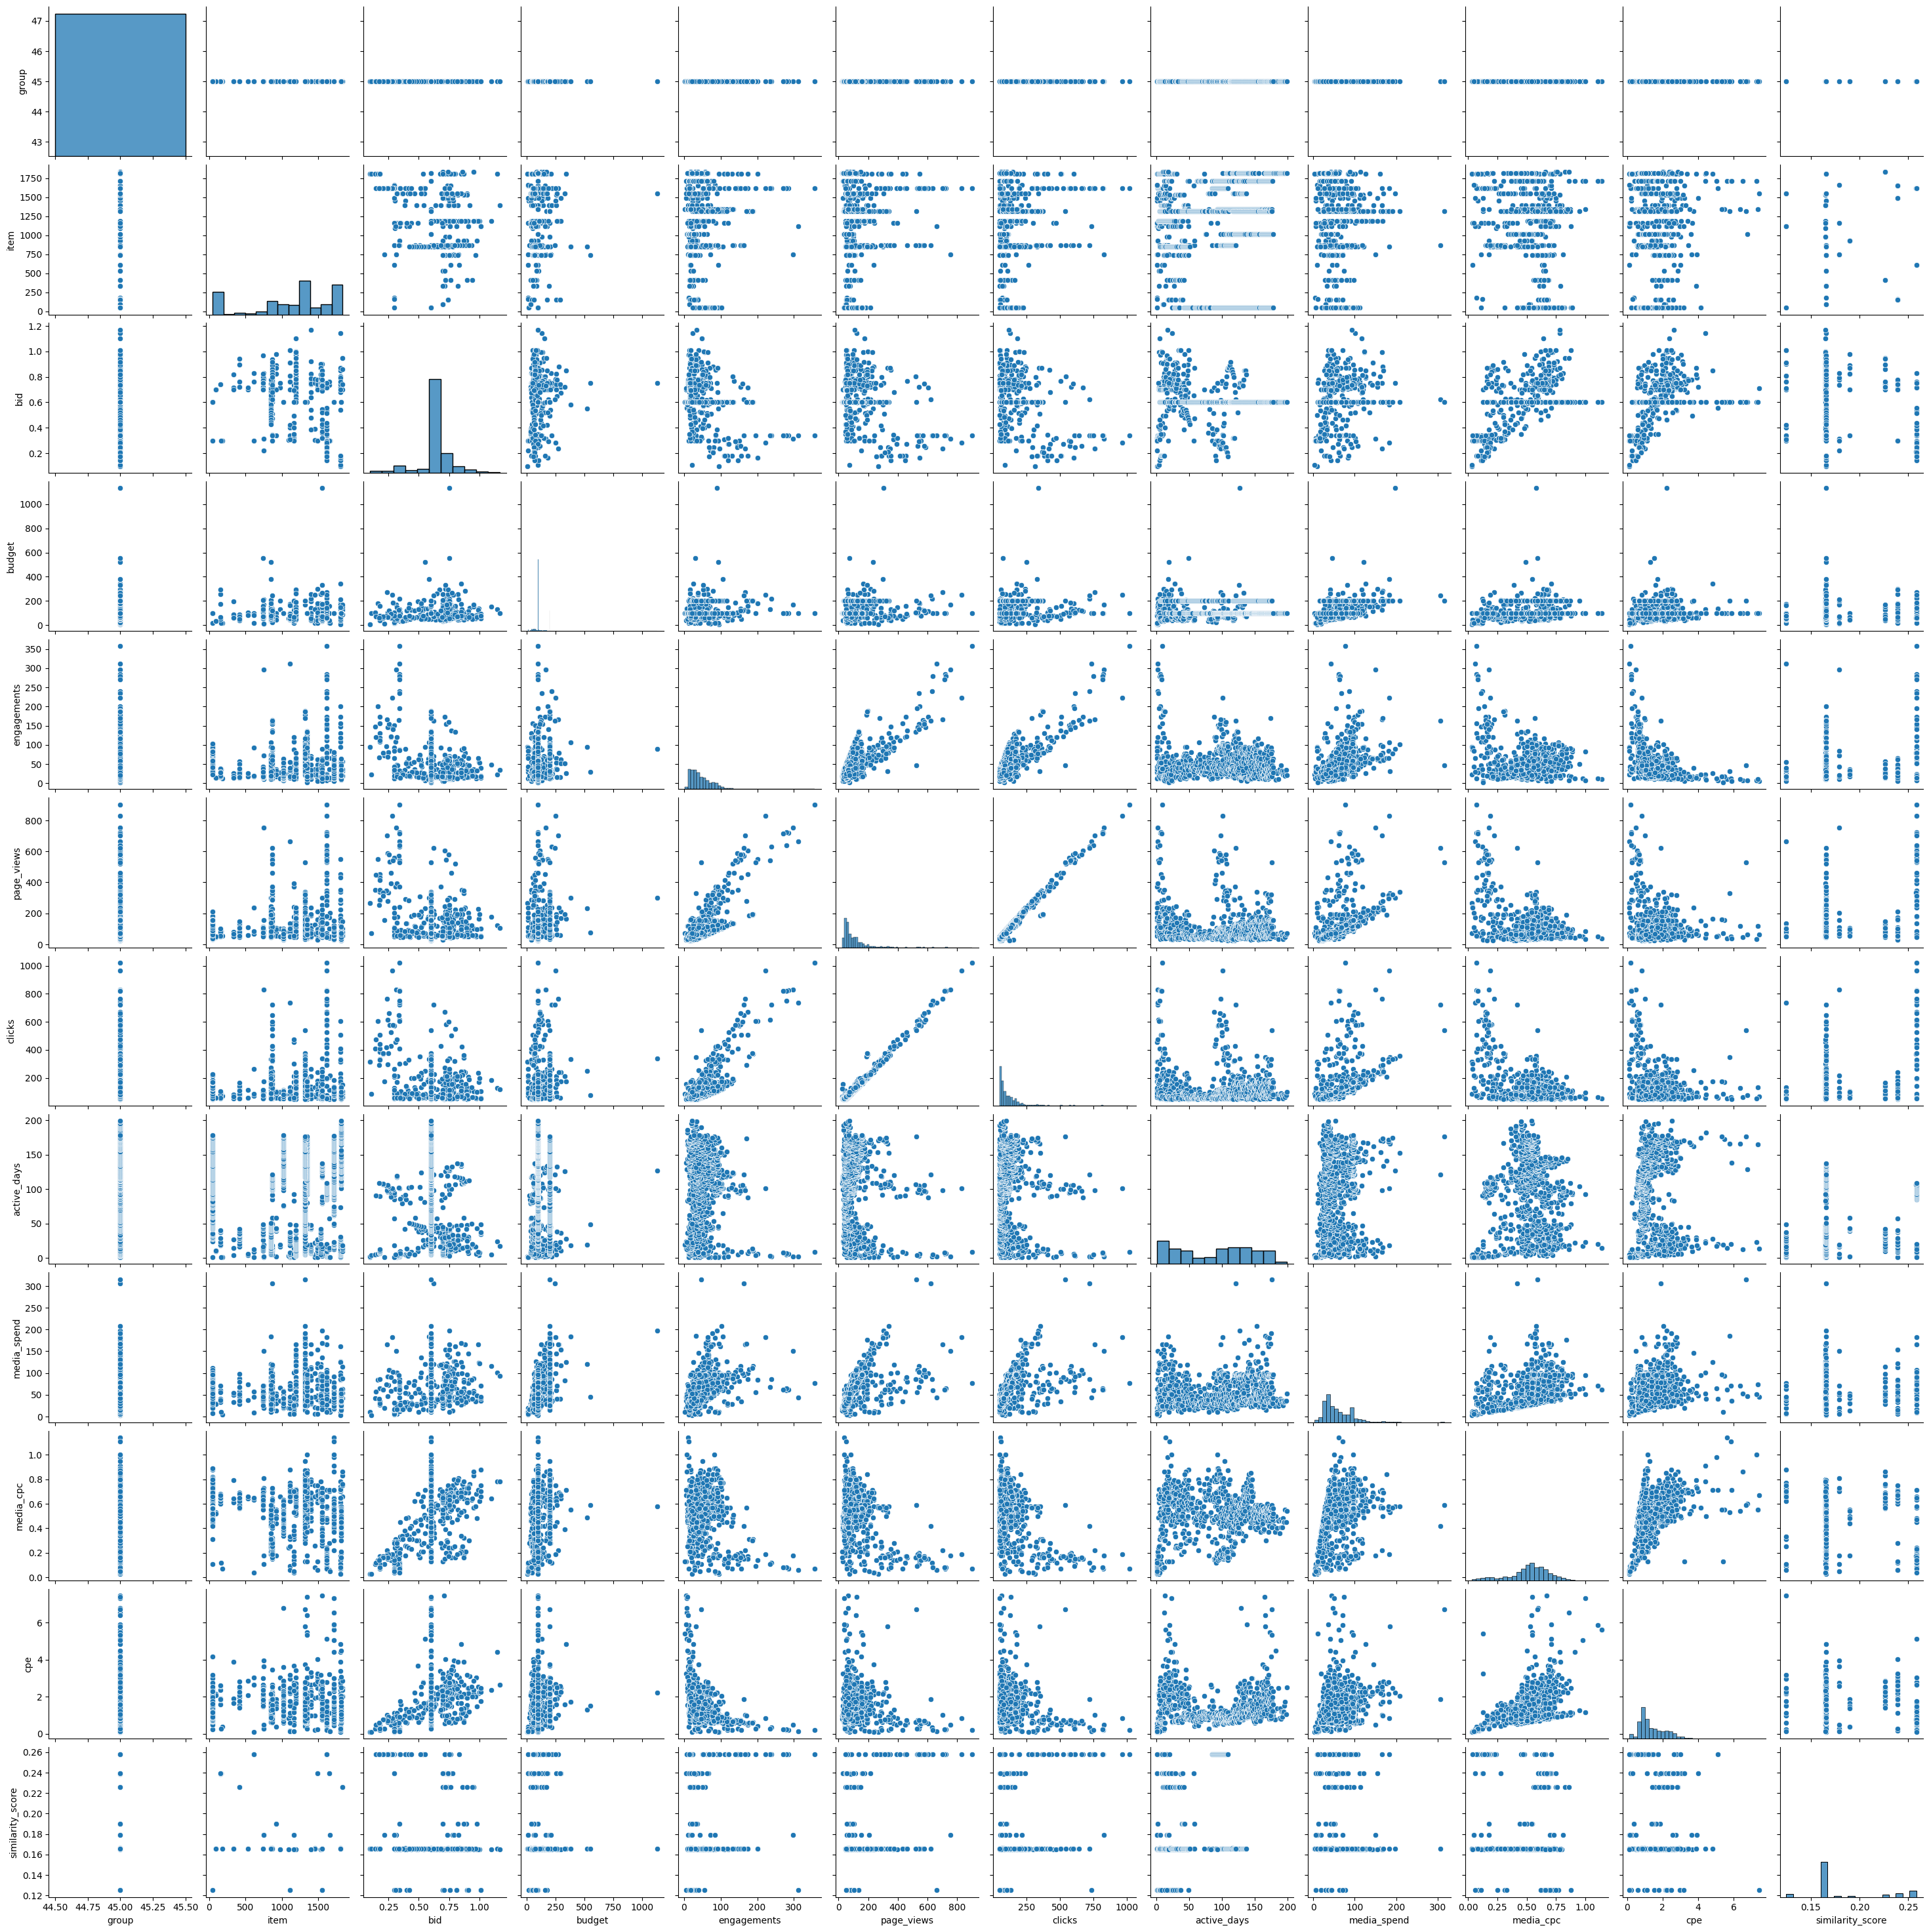

In [46]:
# It is possible to see that group 45 have a complex data sctructure, so it isn't beneficial to remove it entirely.
columns_mask = ['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'similarity_score']

pair_plot_df = data[columns_mask]

group_mask = pair_plot_df['group'] == 45

sns.pairplot(pair_plot_df[group_mask])

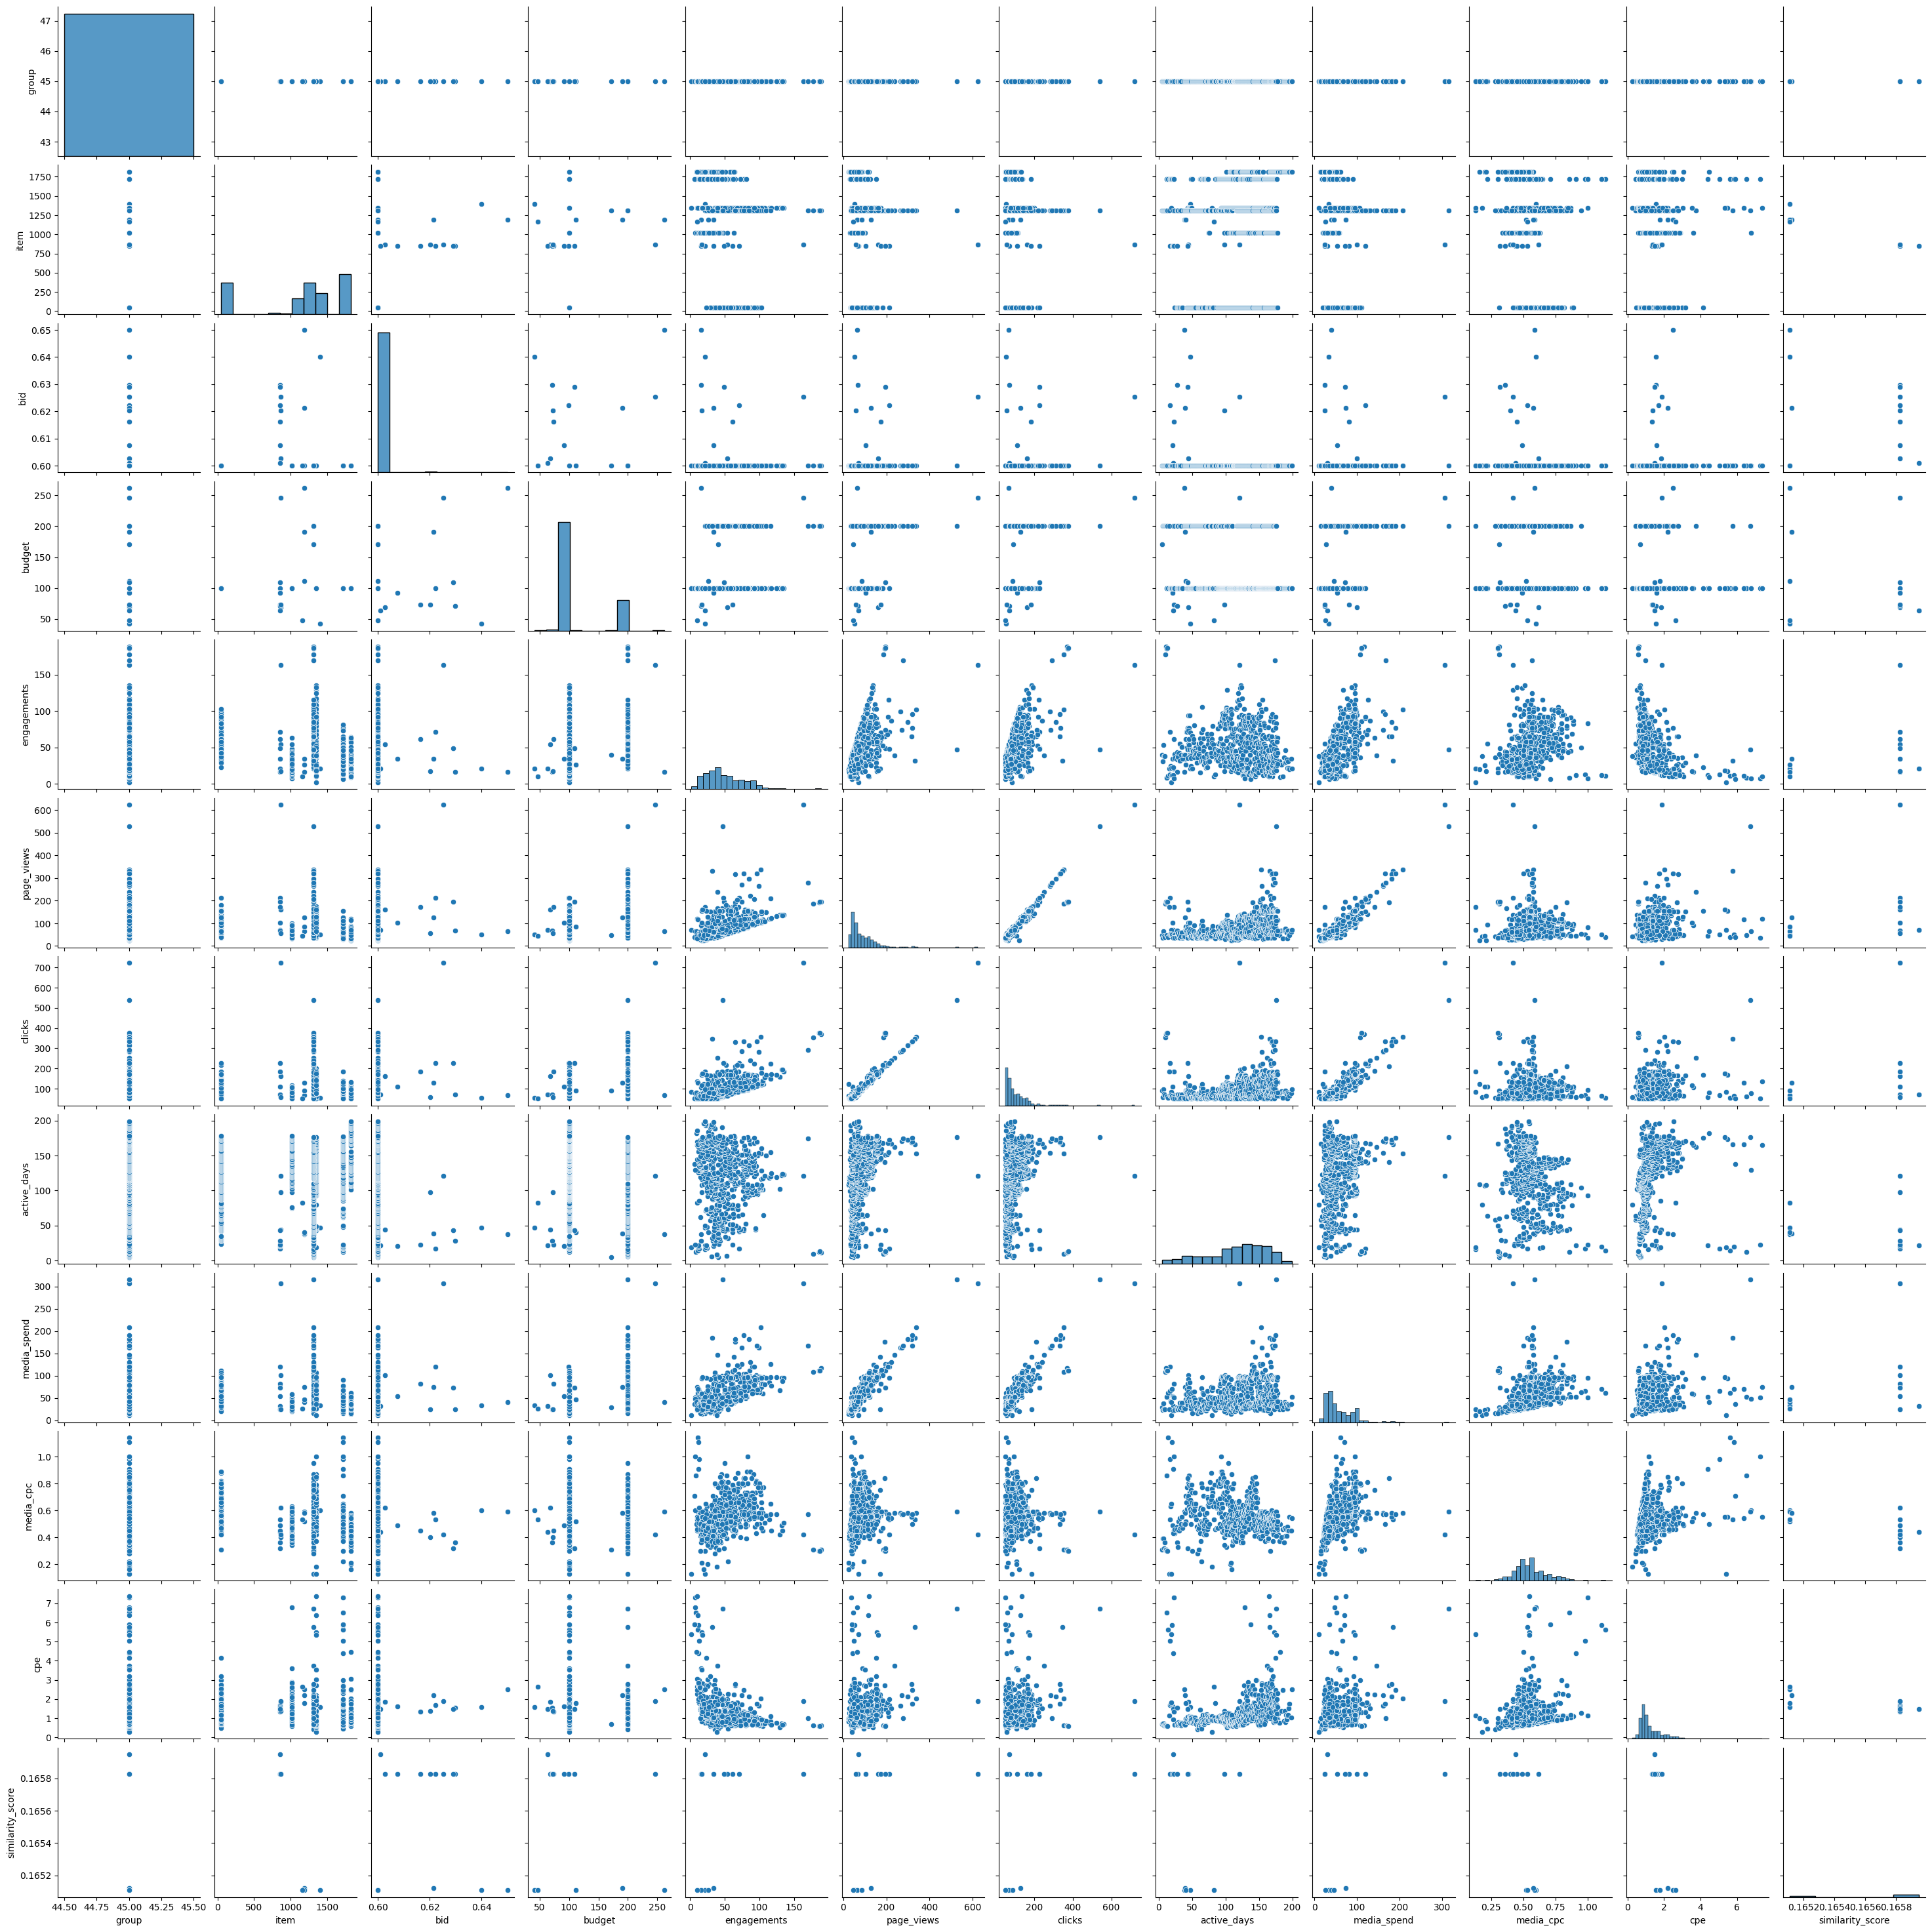

In [47]:
# If we filter by bids, it is possible to see that there is too many bids equal to 0.60 and budgets with 100 and 200. 
# This requires a more detailed analysis with business/product owners to really understand what is going on.
# Later on, I will remove some of these bids data of 0.6 from group 45 so we can end up with a more "explanable" modeling methodology.
bid_mask = data['bid'].between(0.6, 0.65)
sns.pairplot(pair_plot_df[bid_mask])

### Box Plots

With BoxPlots, the unnusual behavior found with group 45 bids around 0.6 can be more visible.


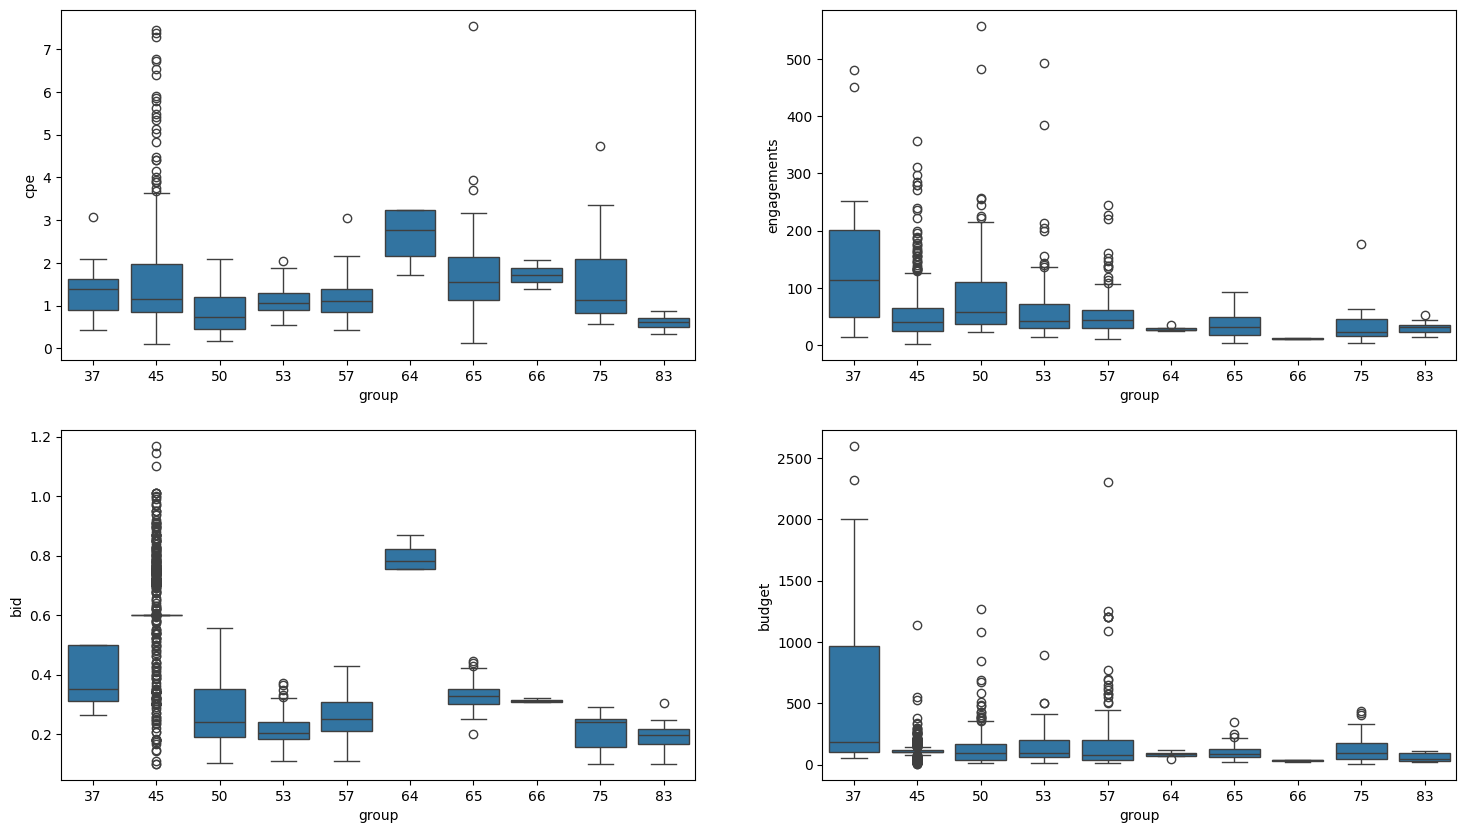

In [48]:
# Box Plots - CPE and Bid per group

# Because of the high number of bids equal to 0.60, the boxplot show a high "outliers" quantity for group 45
# I will remove some of this "focused" data, and we will see how boxplots differ.

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Create plots using Seaborn
sns.boxplot(x='group', y='cpe', data=data, ax=axes[0, 0])
sns.boxplot(x='group', y='engagements', data=data, ax=axes[0, 1])
sns.boxplot(x='group', y='bid', data=data, ax=axes[1, 0])
sns.boxplot(x='group', y='budget', data=data, ax=axes[1, 1])

plt.show()

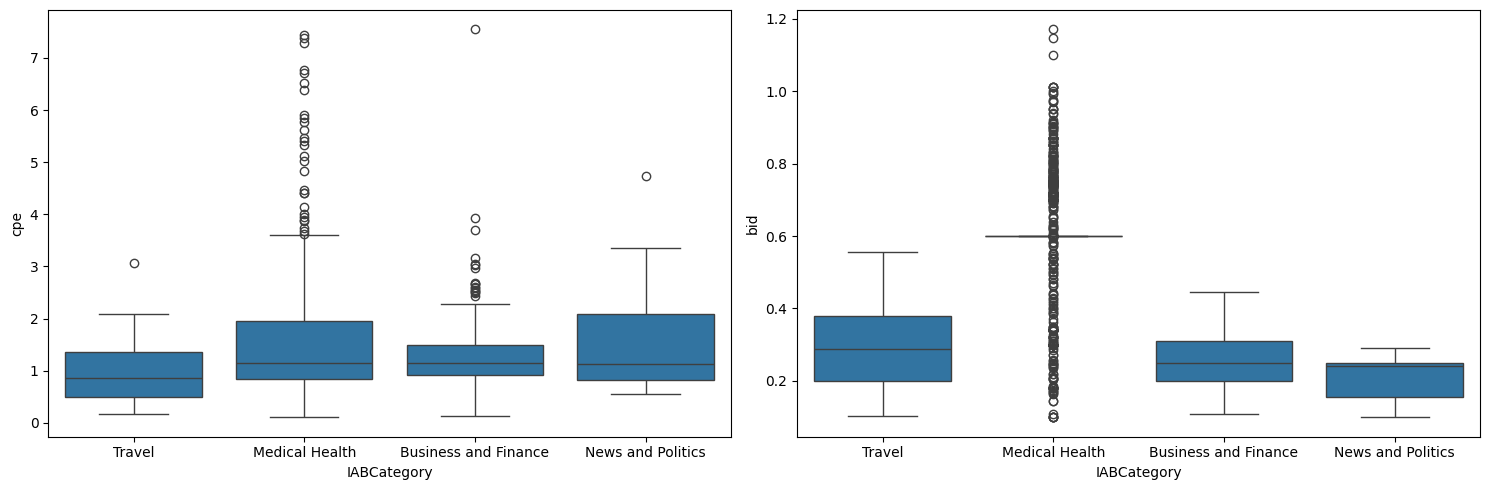

In [49]:
# Box Plots - CPE and Bid per IAB Category

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='IABCategory', y='cpe', data=data, ax=axes[0])
sns.boxplot(x='IABCategory', y='bid', data=data, ax=axes[1])
plt.tight_layout()
plt.show()

# sns.boxplot(x='IABCategory', y='cpe', data=data)
# plt.xticks(rotation=30)
# plt.tight_layout()

In [50]:
data[(data['IABCategory']=='Medical Health') & (data['bid'] >= 0.6) & (data['bid'] <= 0.6009)].groupby('bid')['item'].value_counts()

bid  item
0.6  1314      1
     1314      1
     48        4
     1314      4
     1716      4
     1817      4
     1343      3
     1016      2
     1163      1
     48      129
     1314    123
     1716     96
     1343     85
     1817     63
     1016     62
     1189      1
Name: count, dtype: int64

### Time series graphics

Let's understand if and how data drifted through time.

This analysis is very important because it show us data stability over time. Our model performance depends completly on data quality, i.e., on data stability over time. The best dataset for model training is the one with stable variables (ergodic behaviour) if we choose a "statistical approach" to modelling, such as tree-based algorithms.

Note that the "constant bidding" over time happend mainly during the last avaiable data. Therefore, if we split data to training (train, test) and validation using an out-of-time approach, we may end up with a totally different behaviour and may be fooled to believe our model isn't good enought (overfitted or underfitted).


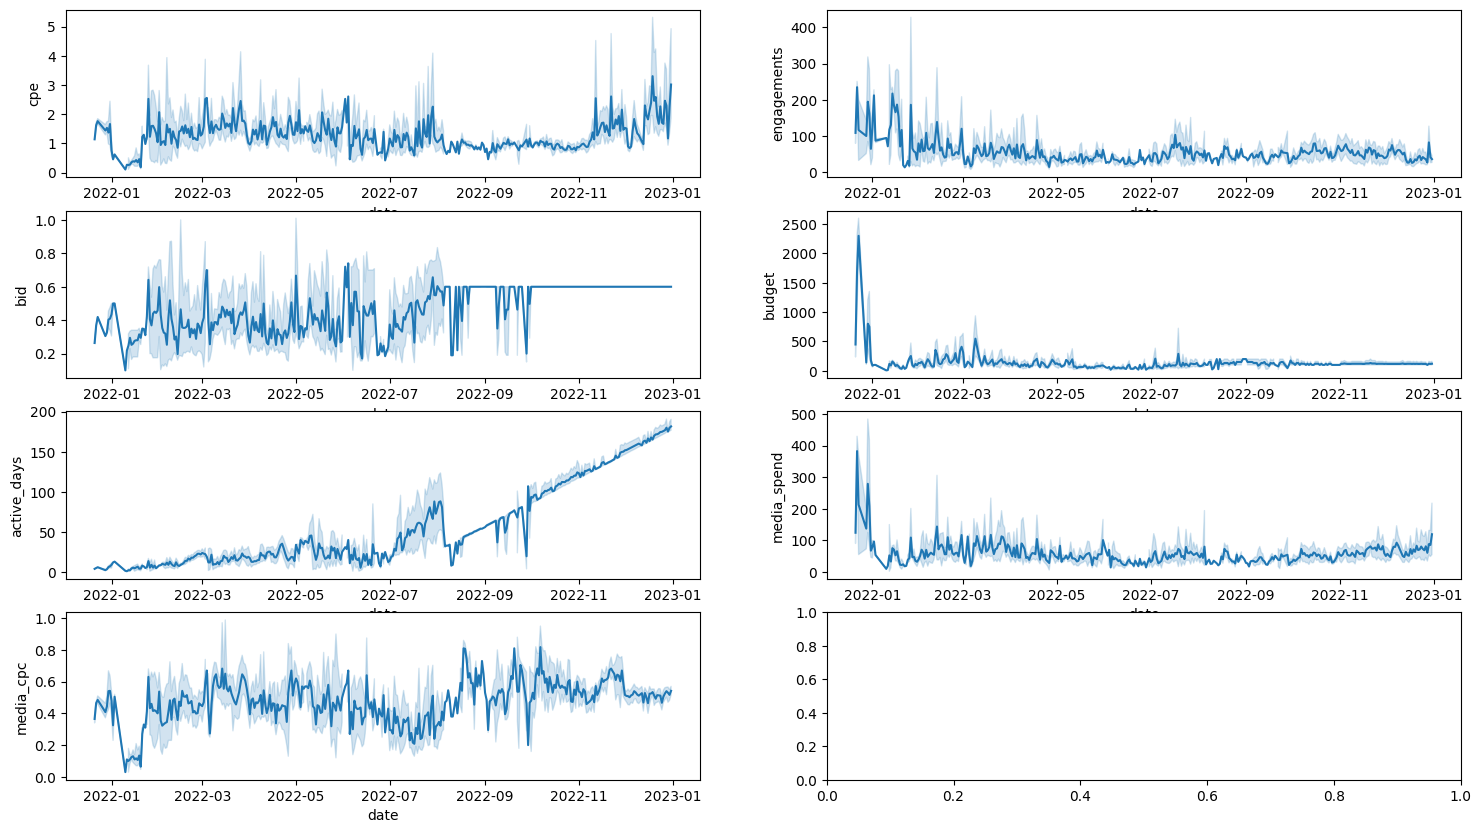

In [51]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 10))

plot_data = data.copy()
plot_data['date'] = pd.to_datetime(plot_data['date'])

# Create plots using Seaborn
sns.lineplot(x='date', y='cpe', data=plot_data, ax=axes[0, 0])
sns.lineplot(x='date', y='engagements', data=plot_data, ax=axes[0, 1])
sns.lineplot(x='date', y='bid', data=plot_data, ax=axes[1, 0])
sns.lineplot(x='date', y='budget', data=plot_data, ax=axes[1, 1])
sns.lineplot(x='date', y='active_days', data=plot_data, ax=axes[2, 0])
sns.lineplot(x='date', y='media_spend', data=plot_data, ax=axes[2, 1])
sns.lineplot(x='date', y='media_cpc', data=plot_data, ax=axes[3, 0])

plt.show()

### Removing anomalous data

We would need to go back with business/product owners to understand "why" there is so many data with the bid set to 0.6;

That behaviour seems to be "manufactured" or influenced by some business strategy. If we use this data in training, we may bias our model toward a behaviour that may not occur again.

In [52]:
# bid       item
# 0.600000  1314      1
#           1314      1
#           48        4
#           1314      4
#           1716      4
#           1817      4
#           1343      3
#           1016      2
#           1163      1
#           48      129
#           1314    123
#           1716     96
#           1343     85
#           1817     63
#           1016     62
#           1189      1

rows_original = data.shape[0]
print("# rows of original dataset: ", rows_original)

# Removes "anomalous" items
data = data[~data['item'].isin([1314, 48, 1716, 1016, 1343, 1817])]

rows_clean = data.shape[0]

print("# rows of cleaned dataset: ", rows_clean)
print(f"{rows_original - rows_clean} rows where removed.")

# rows of original dataset:  1682
# rows of cleaned dataset:  1101
581 rows where removed.


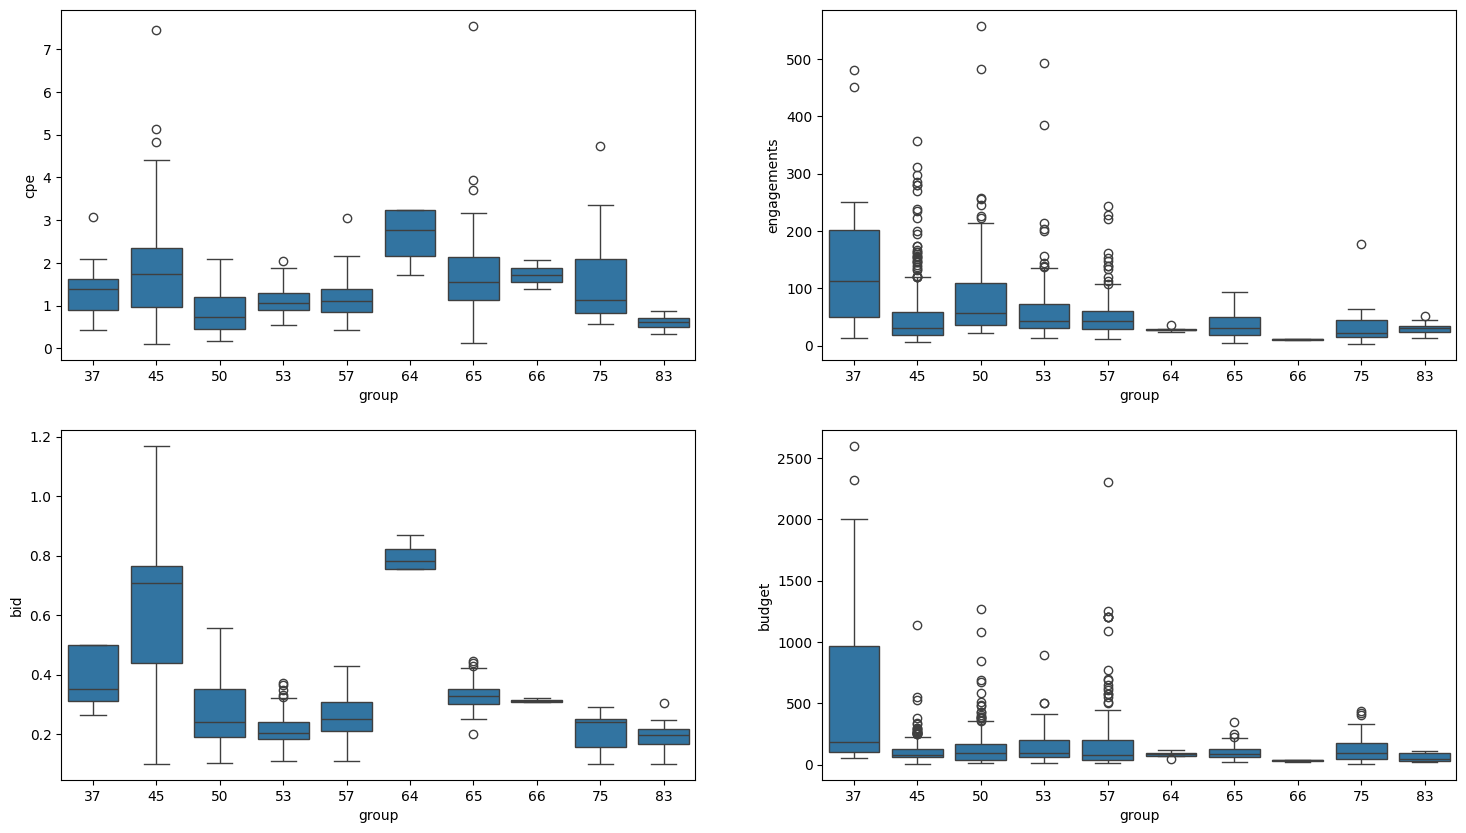

In [53]:
# Let's see how data changed after removing those 0.6 bids

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Create plots using Seaborn
sns.boxplot(x='group', y='cpe', data=data, ax=axes[0, 0])
sns.boxplot(x='group', y='engagements', data=data, ax=axes[0, 1])
sns.boxplot(x='group', y='bid', data=data, ax=axes[1, 0])
sns.boxplot(x='group', y='budget', data=data, ax=axes[1, 1])

plt.show()

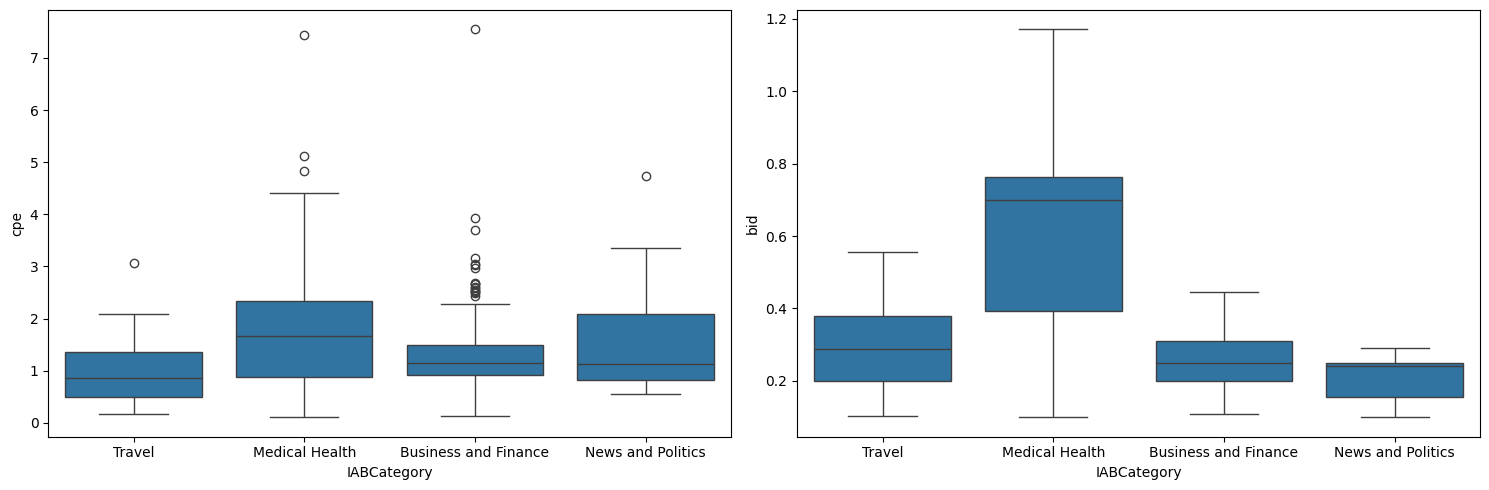

In [54]:
# Box Plots - CPE and Bid per IAB Category

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='IABCategory', y='cpe', data=data, ax=axes[0])
sns.boxplot(x='IABCategory', y='bid', data=data, ax=axes[1])
plt.tight_layout()
plt.show()

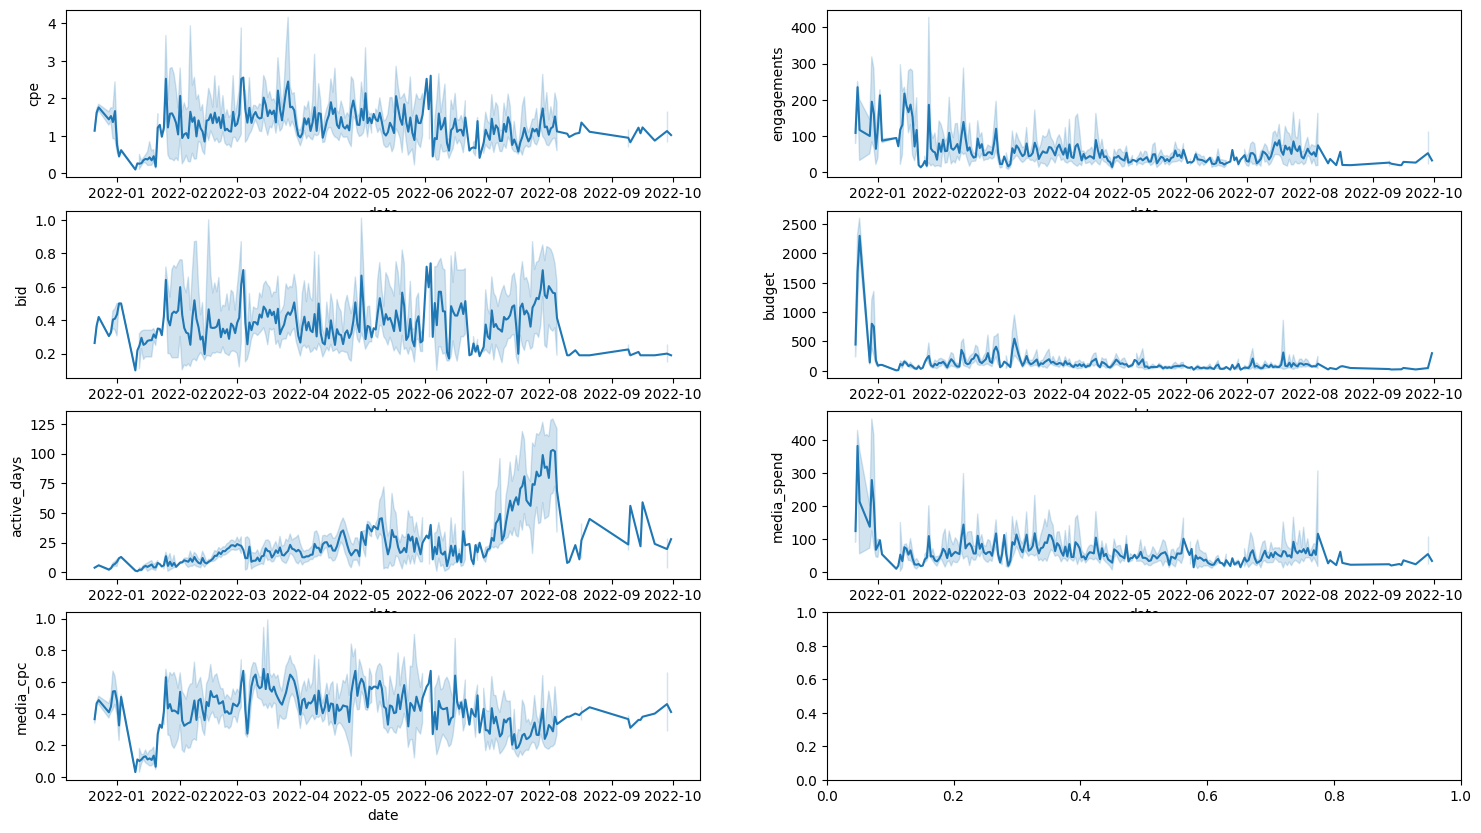

In [55]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 10))

plot_data = data.copy()
plot_data['date'] = pd.to_datetime(plot_data['date'])

# Create plots using Seaborn
sns.lineplot(x='date', y='cpe', data=plot_data, ax=axes[0, 0])
sns.lineplot(x='date', y='engagements', data=plot_data, ax=axes[0, 1])
sns.lineplot(x='date', y='bid', data=plot_data, ax=axes[1, 0])
sns.lineplot(x='date', y='budget', data=plot_data, ax=axes[1, 1])
sns.lineplot(x='date', y='active_days', data=plot_data, ax=axes[2, 0])
sns.lineplot(x='date', y='media_spend', data=plot_data, ax=axes[2, 1])
sns.lineplot(x='date', y='media_cpc', data=plot_data, ax=axes[3, 0])

plt.show()

### Correlation Map

We can analyze correlations, using for example R² ou Spearman's correlation, in order to see which features are more linear correlated to each other. This can give us insights of which variable to use, which to drop, etc.

It is not advisable to use correlated features with a modelling approach that requires independence between the dependent features, such as Linear or Logistic Regression. I am going to use a tree-based modeling, therefor this isn't a big concern as it doesn't hurt any model's "pre-requisites", or key assumptions/hypotheses upon which the model is built.

**Note**: If we use linear regression modeling, we should be aware of the Gauss-Markov assumptions about  linearity, independence, multicolinearity, homoscedasticity, normality, etc.

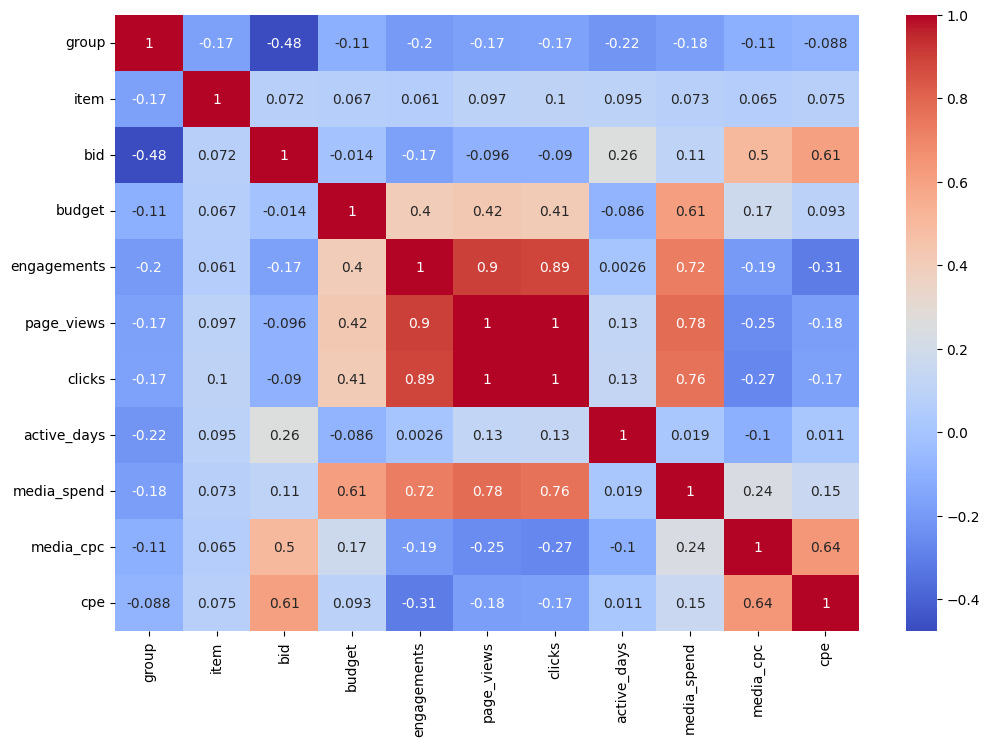

In [56]:
### Correlation map ###
# Store columns names with its data types.
data_types = data.dtypes.to_dict()

# Select numerical variables from data
numerical_columns = [key for key, item in data_types.items() if pd.api.types.is_numeric_dtype(item)]
num_data = data[numerical_columns]

# Correlation Matrix
correlation_matrix = num_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# It is interesting to note that media_cpc have a higher correlation with cpe than media_spend 
# (this is counterintuitive since CPE = media_spend / engagements)

### Note on Outliers removal

I am not going to remove "outliers" because I am going to use tree-based model approach. These models are non-linear and robust to outliers because of how they split the features space.

Note: Outliers processing/removal is very important for linear models, because outliers can significantly impact model's results. 

### Segmentation using Clustering (K-means)

In here, I create a simple segmentation using K-means. I use `bid` to create a new variable called "cluster". This similar as splitting the dataset using two bid ranges, defined by the cluster centers, which indicate the central value of each range. Therefore, we can interpret this as spliting the dataset into "lower bids dataset" and "higher bids dataset".

In this example, this simple model trained (that depends only on `bid`) does not bennefit from this segmentation.

The following approach is just an example to show how one could use this methodology. More interesting segmentations could be achieved by using targeting or categories features, for example.

In [57]:
# Creates scorers for the Cross-Validation function `cross_val_score`
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# K-Means Segmentation
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[['bid']])
data['cluster_bid'] = kmeans.labels_

  File "c:\Users\Renata Martines\OneDrive\Documents\Lais\github\inpowered_datachallenge\ipwvenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [58]:
# Now we train two different models for each cluster
models = {}
for cluster in data['cluster_bid'].unique():
    cluster_data = data[data['cluster_bid'] == cluster]
    X = cluster_data[['bid', 'budget']]
    y = cluster_data['cpe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    model = GradientBoostingRegressor(random_state=0)
    model.fit(X_train, y_train)
    models[cluster] = model

# Model evaluation
overall_scores = []
for cluster, model in models.items():
    cluster_data = data[data['cluster_bid'] == cluster]
    X = cluster_data[['bid', 'budget']]
    y = cluster_data['cpe']
    scores = cross_val_score(model, X, y, cv=5, scoring=mape_scorer)
    overall_scores.append(scores.mean())
    print(f'Cluster {cluster} - CV MAPE Scores: {scores} - Mean: {scores.mean():.3f}')

print(f'Overall performance (Mean MAPE): {np.array(overall_scores).mean():.3f}')

Cluster 0 - CV MAPE Scores: [-1.7842965  -0.58795782 -0.24868374 -0.2020791  -0.38728198] - Mean: -0.642
Cluster 1 - CV MAPE Scores: [-0.24035159 -0.23625771 -0.21148808 -0.60158251 -0.92076106] - Mean: -0.442
Overall performance (Mean MAPE): -0.542


In [59]:
# Training without bid segmentation
X = data[['bid', 'budget']]
y = data['cpe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = GradientBoostingRegressor(random_state=0)
model.fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5, scoring=mape_scorer)
print(f'CV MAPE Scores: {scores} - Mean: {scores.mean():.3f}')

CV MAPE Scores: [-1.11965012 -0.80884974 -0.38379074 -0.19652281 -0.36634483] - Mean: -0.575


## Baseline Model Training & Evaluation

First, let's split data into training, testing and validation sets. I will separate the last available data, from the last X days/months (out-of-time sample), to use as the validation dataset. This sample is only used to evaluate the final model, which is usually chosen based on the results from the test dataset.

The training and test sets can now be used freely to train different models and select the best-performing one. The validation set is used only to guarantee the performance and stability of the best-performing model. It is not recommended to use validation sets to select models, as this may introduce temporal bias. However, there are some cases where this is unavoidable due to the fast pace and dynamics of the problem.

### Feature Selection for Model Training 

In [60]:
### Handling missing values ###

# Since we only have missing values in categories with object-type features, and I am going to use a tree-based model, I will input missings with `-999999999999` tag.
# This helps tree-based models to "differentiate" data with and without information, by spliting missing data into different subtrees.
# This performs similar as a model specifically trained for/with datasets without these information.
# For numerical data, we also could use other values such as columns (or cluster) medians, means, etc.
# Independent if the variable type, if it is numeric or categorical, I usually prefer to use a standard number tag (such as -999999999999),
# when developing a tree-based baseline model.

# data.fillna(value=-999999999999, inplace=True)

In [61]:
data.columns

Index(['group', 'item', 'channel', 'date', 'bid', 'budget', 'engagements',
       'page_views', 'clicks', 'active_days', 'media_spend', 'media_cpc',
       'cpe', 'headline', 'storySummary', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'CATEGORY_1', 'targetGeo', 'targetInterest',
       'targetGeo_cityName', 'targetGeo_regionName',
       'targetInterest_interestName', 'targetInterest_interestName_cleaned',
       'targetGeo_regionName_cleaned', 'creative', 'similarity_score',
       'log_bid', 'budget_bid', 'bid_bins', 'cluster_bid'],
      dtype='object')

In [86]:
### Selecting which columns will be used in training ###

columns_mask = [
#'group', 
#'item', 
'channel', 
'date', 
'bid', 
'budget', 
#'engagements',
#'page_views', 
#'clicks', 
#'active_days', 
#'media_spend', 
#'media_cpc',
'cpe', 
#'headline', 
#'storySummary', 
'IABCategory', 
'targetAge',
'targetOs', 
'targetGender', 
#'CATEGORY_1', 
#'targetGeo', 
#'targetInterest',
#'targetGeo_cityName', 
#'targetGeo_regionName',
#'targetInterest_interestName', 
'targetInterest_interestName_cleaned',
'targetGeo_regionName_cleaned', 
#'creative', 
'similarity_score',
'log_bid', 
'budget_bid'#, 
#'bid_bins'
]

modelling_data = data[columns_mask].copy()
modelling_data

channel        date       bid       budget       cpe     IABCategory  \
0      YAHOO  2021-12-21  0.263696   660.923913  1.147174          Travel   
1      YAHOO  2021-12-21  0.263043   235.217391  1.131000          Travel   
2      YAHOO  2021-12-22  0.366809  1060.638298  1.712430          Travel   
3      YAHOO  2021-12-22  0.367447  2317.021277  1.534566          Travel   
4      YAHOO  2021-12-23  0.419130  2600.000000  1.847512          Travel   
...      ...         ...       ...          ...       ...             ...   
1677   YAHOO  2022-06-15  0.185714    33.363516  0.541714  Medical Health   
1678   YAHOO  2022-06-21  0.205591    51.989247  0.619677  Medical Health   
1679   YAHOO  2022-06-25  0.220000    46.684211  0.829032  Medical Health   
1680   YAHOO  2022-07-02  0.240000    21.718539  0.654500  Medical Health   
1681   YAHOO  2022-07-03  0.245595    25.745357  0.649545  Medical Health   

     targetAge  targetOs targetGender targetInterest_interestName_cleaned  \
0          NaN       NaN          NaN                                none   
1          NaN       NaN          NaN                                none   
2          NaN       NaN          NaN                                none   
3          NaN       NaN          NaN                                none   
4          NaN       NaN          NaN                                none   
...        ...       ...          ...                                 ...   
1677      65+;      IOS;        MALE;                Fitness and wellness   
1678      65+;      IOS;        MALE;                Fitness and wellness   
1679      65+;  ANDROID;      FEMALE;                         Health care   
1680      65+;      IOS;        MALE;                Fitness and wellness   
1681      65+;      IOS;        MALE;                Fitness and wellness   

     targetGeo_regionName_cleaned  similarity_score   log_bid   budget_bid  
0     ['MD', 'OH', 'PA', 'DC/MD']               NaN -1.332960  2506.389118  
1     ['MD', 'OH', 'PA', 'DC/MD']               NaN -1.335436   894.214876  
2     ['MD', 'OH', 'PA', 'DC/MD']               NaN -1.002915  2891.531323  
3     ['MD', 'OH', 'PA', 'DC/MD']               NaN -1.001177  6305.732484  
4     ['MD', 'OH', 'PA', 'DC/MD']               NaN -0.869573  6203.319502  
...                           ...               ...       ...          ...  
1677                          NaN          0.325213 -1.683546   179.649704  
1678                          NaN          0.325213 -1.581865   252.876569  
1679                          NaN          0.278709 -1.514128   212.200957  
1680                          NaN          0.325213 -1.427116    90.493914  
1681                          NaN          0.325213 -1.404070   104.828405  

[1101 rows x 14 columns]

In [87]:
# This is necessary to perform OHE later
modelling_data['targetGeo_regionName_cleaned'] = modelling_data['targetGeo_regionName_cleaned'].apply(lambda x: ['NULL'] if x is np.nan else x)
# modelling_data['targetGeo_regionName_cleaned'][100]

In [88]:
# Lets' split data into development and validation sets
modelling_data['date']

0       2021-12-21
1       2021-12-21
2       2021-12-22
3       2021-12-22
4       2021-12-23
           ...    
1677    2022-06-15
1678    2022-06-21
1679    2022-06-25
1680    2022-07-02
1681    2022-07-03
Name: date, Length: 1101, dtype: object

In [89]:
### Split data into development (for training and testing) and validation ###

# Set the cutoff date for validation set (last 3 months)
cutoff_date = '2022-04-03'

# Filter out the development and validation set based on date
development_set = modelling_data[modelling_data['date'] < cutoff_date].copy()
validation_set_oot = modelling_data[modelling_data['date'] >= cutoff_date].copy()

# Optional: Take a random sample (e.g., 10%) from the entire dataset to add to the validation set
random_sample = modelling_data.sample(frac=0.1, random_state=10)

# Combine the random sample with the validation set (make sure there are no duplicates)
validation_set = pd.concat([validation_set_oot, random_sample], ignore_index=True)

In [90]:
### One Hot Encoding of Categorical variables ###

# Here I am going to use a previous list generated. This is like using all dataset to generate tags, and is similar to the "time poisoning" problem.
# But as we are dealing with USA States, I am assuming an approximation here, and saying that this won't significantly impact models performance.
# Note: the ideal here is to generate the unique_values list from each development and validation datasets separately, but I won't because of my limited avaiable time;

# Create new columns for each tag and fill them with 0 or 1
for tag in list(unique_values):
    development_set[f'{tag}'] = development_set['targetGeo_regionName_cleaned'].apply(lambda x: 1 if tag in x else 0)

# Drop the original column
development_set.drop('targetGeo_regionName_cleaned', axis=1, inplace=True)

# Create new columns for each tag and fill them with 0 or 1
for tag in list(unique_values):
    validation_set[f'{tag}'] = validation_set['targetGeo_regionName_cleaned'].apply(lambda x: 1 if tag in x else 0)

# Drop the original column
validation_set.drop('targetGeo_regionName_cleaned', axis=1, inplace=True)

In [91]:
validation_set

channel        date       bid      budget       cpe  \
0         YAHOO  2022-04-03  0.740000  256.506947  1.584737   
1         YAHOO  2022-04-03  0.900000   67.390000  2.137647   
2         YAHOO  2022-04-04  0.810000  100.000000  2.408000   
3         YAHOO  2022-04-05  0.950000  150.374737  2.366757   
4         YAHOO  2022-04-06  0.712500  106.977500  1.658929   
..          ...         ...       ...         ...       ...   
708  REVCONTENT  2022-03-06  0.300000  100.000000  1.687500   
709       YAHOO  2022-03-16  0.237634  216.609892  1.432456   
710       YAHOO  2022-07-13  0.259302   55.000000  0.546500   
711       YAHOO  2022-03-23  0.285851   67.064362  1.021282   
712       YAHOO  2022-04-21  0.200000   49.635056  0.868039   

              IABCategory targetAge  targetOs targetGender  \
0          Medical Health    55-64;      IOS;        MALE;   
1          Medical Health    55-64;      IOS;        MALE;   
2          Medical Health      65+;      IOS;        MALE;   
3          Medical Health      65+;  ANDROID;        MALE;   
4          Medical Health      65+;      IOS;        MALE;   
..                    ...       ...       ...          ...   
708  Business and Finance       NaN       NaN          NaN   
709  Business and Finance    35-44;      IOS;        MALE;   
710  Business and Finance       NaN       NaN          NaN   
711  Business and Finance      65+;  ANDROID;        MALE;   
712  Business and Finance      65+;      IOS;        MALE;   

    targetInterest_interestName_cleaned  similarity_score   log_bid  \
0                         Heart Disease          0.239108 -0.301105   
1               Hypertension Propensity          0.125077 -0.105361   
2               Hypertension Propensity          0.125077 -0.210721   
3    Hypertension Propensity Caregivers          0.225913 -0.051293   
4               Hypertension Propensity          0.165826 -0.338975   
..                                  ...               ...       ...   
708                                none               NaN -1.203973   
709                          Technology          0.234933 -1.437022   
710                                none               NaN -1.349761   
711                           Insurance          0.226564 -1.252284   
712                           Insurance          0.211756 -1.609438   

     budget_bid  MO  NH  IN  MT  NM  OR  CO  NV  UT  NE  TX  ND  MI  IL  CA  \
0    346.631010   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     74.877778   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    123.456790   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    158.289197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    150.143860   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..          ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
708  333.333333   1   0   1   0   0   0   0   0   0   1   0   1   1   1   0   
709  911.525792   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
710  212.107623   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   
711  234.612951   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   
712  248.175281   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   

     OH  ME  GA  KY  AR  WI  VT  VA  LA  MD  WY  MS  WA  TN  ID  NC  SD  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
708   1   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   1   
709   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
710   1   1   0   0   0   1  

### Feature Selection for Model Training 

In [92]:
# Handling missing values

# Since we only have missing values in categories with object-type features, and I am going to use a tree-based model, I will input missings with `-999999999999` tag.
# This helps tree-based models to "differentiate" data with and without information, by spliting missing data into different subtrees.
# This performs similar as a model specifically trained for/with datasets without these information.
# For numerical data, we also could use other values such as columns (or cluster) medians, means, etc.
# Independent if the variable type, if it is numeric or categorical, I usually prefer to use a standard number tag (such as -999999999999),
# when developing a tree-based baseline model.

### Missings Inputs ###

validation_set = validation_set.replace(to_replace='none', value=np.nan)
validation_set = validation_set.fillna('-999999999999')

development_set = development_set.replace(to_replace='none', value=np.nan)
development_set = development_set.fillna('-999999999999')

### Model Development


In [93]:
development_set.columns

Index(['channel', 'date', 'bid', 'budget', 'cpe', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'targetInterest_interestName_cleaned',
       'similarity_score', 'log_bid', 'budget_bid', 'MO', 'NH', 'IN', 'MT',
       'NM', 'OR', 'CO', 'NV', 'UT', 'NE', 'TX', 'ND', 'MI', 'IL', 'CA', 'OH',
       'ME', 'GA', 'KY', 'AR', 'WI', 'VT', 'VA', 'LA', 'MD', 'WY', 'MS', 'WA',
       'TN', 'ID', 'NC', 'SD', 'DC/MD', 'KS', 'AZ', 'IA', 'AL', 'OK', 'MN',
       'PA'],
      dtype='object')

In [94]:
train_columns = ['channel', 'bid', 'budget', 'cpe', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'targetInterest_interestName_cleaned',
       'similarity_score', 'log_bid', 'budget_bid', 'AR', 'MD', 'DC/MD', 'NE',
       'NH', 'NM', 'MI', 'ND', 'IL', 'IN', 'TN', 'GA', 'CA', 'VT', 'MS', 'ID',
       'PA', 'NV', 'CO', 'WA', 'SD', 'KY', 'MO', 'TX', 'WY', 'AL', 'AZ', 'MT',
       'ME', 'KS', 'IA', 'OH', 'LA', 'WI', 'NC', 'UT', 'OR', 'OK', 'VA', 'MN']

development_set_train = development_set[train_columns].copy()

In [95]:
# Split data

x_columns = ['channel', 'bid', 'budget', 'IABCategory', 'targetAge',
       'targetOs', 'targetGender', 'targetInterest_interestName_cleaned',
       'similarity_score', 'log_bid', 'budget_bid', 'AR', 'MD', 'DC/MD', 'NE',
       'NH', 'NM', 'MI', 'ND', 'IL', 'IN', 'TN', 'GA', 'CA', 'VT', 'MS', 'ID',
       'PA', 'NV', 'CO', 'WA', 'SD', 'KY', 'MO', 'TX', 'WY', 'AL', 'AZ', 'MT',
       'ME', 'KS', 'IA', 'OH', 'LA', 'WI', 'NC', 'UT', 'OR', 'OK', 'VA', 'MN']

       
print(development_set_train[x_columns].shape)
print(development_set_train['cpe'].shape)

(498, 51)
(498,)


In [101]:
# Select the training and testing sets
categorical_features = ['channel', 'IABCategory', 'targetAge', 'targetOs', 'targetGender', 'targetInterest_interestName_cleaned']
numerical_features = ['bid', 'budget', 'similarity_score', 'log_bid', 'budget_bid']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor()) # We could also experiment with different algorithms like Random Forest, Gradient Boosting, or XGBoost. But I will attain to the RandomForestRegressor
])

# Split data
X = development_set_train[x_columns]
y = development_set_train['cpe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

### Calculate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE). ###

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Best model evaluation
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.255772343833294


## Feature Analysis and Model Validation

                                              Feature  Importance
3                          IABCategory_Medical Health    0.356445
0                                  channel_REVCONTENT    0.336457
4                                  IABCategory_Travel    0.086049
1                                       channel_YAHOO    0.067507
7                                    targetAge_45-54;    0.038881
8                                    targetAge_55-64;    0.030606
24     targetInterest_interestName_cleaned_Technology    0.022276
14                               targetGender_FEMALE;    0.014044
13                         targetGender_-999999999999    0.010217
20  targetInterest_interestName_cleaned_Hypertensi...    0.006242
25         targetInterest_interestName_cleaned_Travel    0.004661
17  targetInterest_interestName_cleaned_Business a...    0.004114
9                                      targetAge_65+;    0.003972
30                                         budget_bid    0.003474
19  target

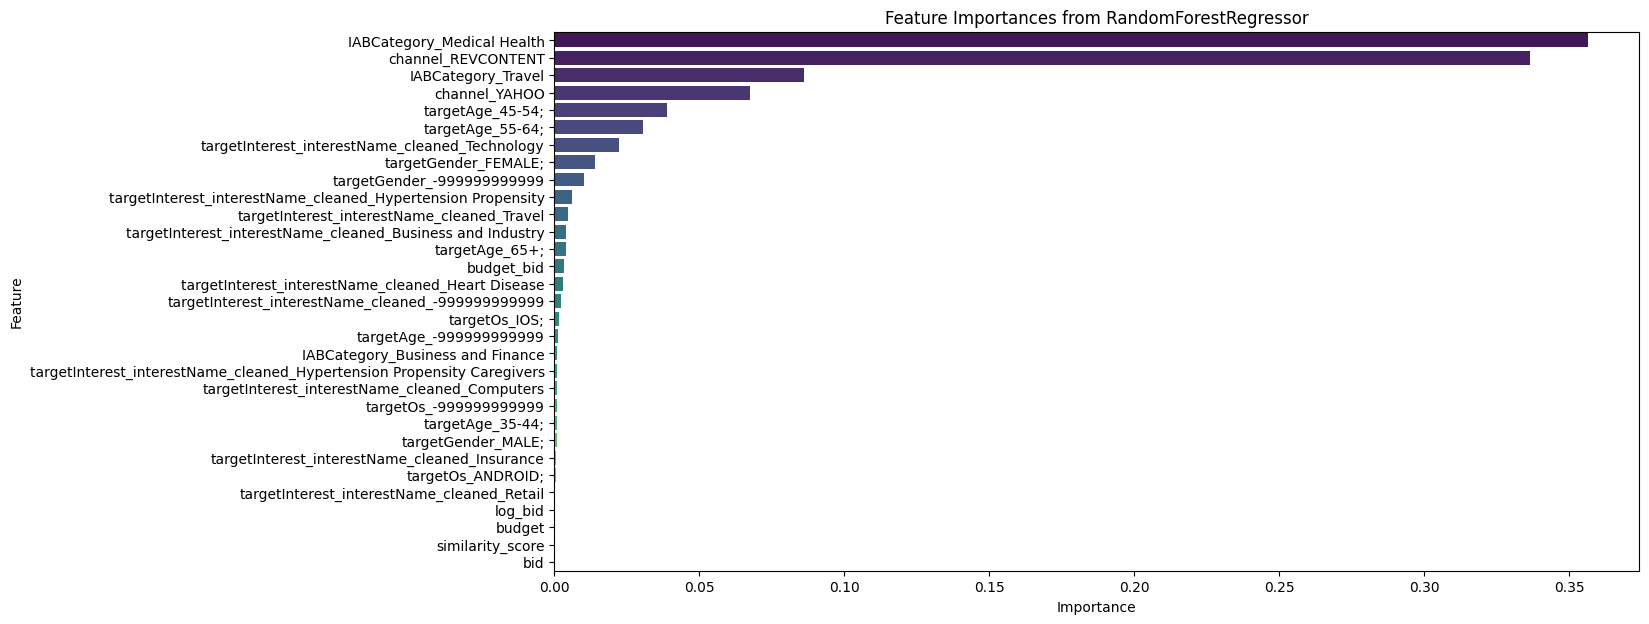

In [126]:

### Perform feature importance analysis to understand which features are most influential. ###

# It is possible to see that the IABCategory "Medical Category" and the REVCONTENT channel plays a significant role to RF predictions.

model_RF = model.named_steps['regressor']

# Get feature importances
importances = model_RF.feature_importances_

# Get feature names from the preprocessor
one_hot_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
# Getting feature names for one-hot encoded columns
encoded_features = one_hot_encoder.get_feature_names_out(categorical_features)
# Combine numerical and encoded categorical feature names
feature_names = list(encoded_features) + numerical_features

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(14, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importances from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [128]:
### Plot predicted vs actual values to visually inspect model performance. ###

with open('RandomForestRegressor_baseline.pkl', 'rb') as f:
    model = pickle.load(f)

# Applying the loaded model to the validation data
X_validation = validation_set[x_columns]
y_validation = validation_set['cpe']
y_validation_pred = model.predict(X_validation)

# Validation error
print("Validation MAE: ", mean_absolute_error(y_validation, y_validation_pred))
print("Validation MAPE: ", mean_absolute_percentage_error(y_validation, y_validation_pred))


# Append predictions to the validation DataFrame
validation_set['y_pred'] = y_validation_pred
validation_set

Validation MAE:  0.5075183449540542
Validation MAPE:  0.5057490063722743


channel        date       bid      budget       cpe  \
0         YAHOO  2022-04-03  0.740000  256.506947  1.584737   
1         YAHOO  2022-04-03  0.900000   67.390000  2.137647   
2         YAHOO  2022-04-04  0.810000  100.000000  2.408000   
3         YAHOO  2022-04-05  0.950000  150.374737  2.366757   
4         YAHOO  2022-04-06  0.712500  106.977500  1.658929   
..          ...         ...       ...         ...       ...   
708  REVCONTENT  2022-03-06  0.300000  100.000000  1.687500   
709       YAHOO  2022-03-16  0.237634  216.609892  1.432456   
710       YAHOO  2022-07-13  0.259302   55.000000  0.546500   
711       YAHOO  2022-03-23  0.285851   67.064362  1.021282   
712       YAHOO  2022-04-21  0.200000   49.635056  0.868039   

              IABCategory      targetAge       targetOs   targetGender  \
0          Medical Health         55-64;           IOS;          MALE;   
1          Medical Health         55-64;           IOS;          MALE;   
2          Medical Health           65+;           IOS;          MALE;   
3          Medical Health           65+;       ANDROID;          MALE;   
4          Medical Health           65+;           IOS;          MALE;   
..                    ...            ...            ...            ...   
708  Business and Finance  -999999999999  -999999999999  -999999999999   
709  Business and Finance         35-44;           IOS;          MALE;   
710  Business and Finance  -999999999999  -999999999999  -999999999999   
711  Business and Finance           65+;       ANDROID;          MALE;   
712  Business and Finance           65+;           IOS;          MALE;   

    targetInterest_interestName_cleaned similarity_score   log_bid  \
0                         Heart Disease         0.239108 -0.301105   
1               Hypertension Propensity         0.125077 -0.105361   
2               Hypertension Propensity         0.125077 -0.210721   
3    Hypertension Propensity Caregivers         0.225913 -0.051293   
4               Hypertension Propensity         0.165826 -0.338975   
..                                  ...              ...       ...   
708                       -999999999999    -999999999999 -1.203973   
709                          Technology         0.234933 -1.437022   
710                       -999999999999    -999999999999 -1.349761   
711                           Insurance         0.226564 -1.252284   
712                           Insurance         0.211756 -1.609438   

     budget_bid  MO  NH  IN  MT  NM  OR  CO  NV  UT  NE  TX  ND  MI  IL  CA  \
0    346.631010   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     74.877778   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    123.456790   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3    158.289197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    150.143860   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..          ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
708  333.333333   1   0   1   0   0   0   0   0   0   1   0   1   1   1   0   
709  911.525792   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
710  212.107623   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   
711  234.612951   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   
712  248.175281   1   1   1   1   1   1   1   1   1   1   0   1   1   1   0   

     OH  ME  GA  KY  AR  WI  VT  VA  LA  MD  WY  MS  WA  TN  ID  NC  SD  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
708   1   0   0   1   0   1   0   0   0   0   0

In [114]:
### Track model performance over time (using the validation dataset) to detect any degradation. ###

# Calculate the absolute error
validation_set['absolute_error'] = abs(validation_set['cpe'] - validation_set['y_pred'])

# Group by date and calculate MAE for each day
daily_mae = validation_set.groupby('date')['absolute_error'].mean().reset_index()
daily_mae = daily_mae[['date', 'absolute_error']]
daily_mae.rename(columns={'absolute_error': 'MAE'}, inplace=True)

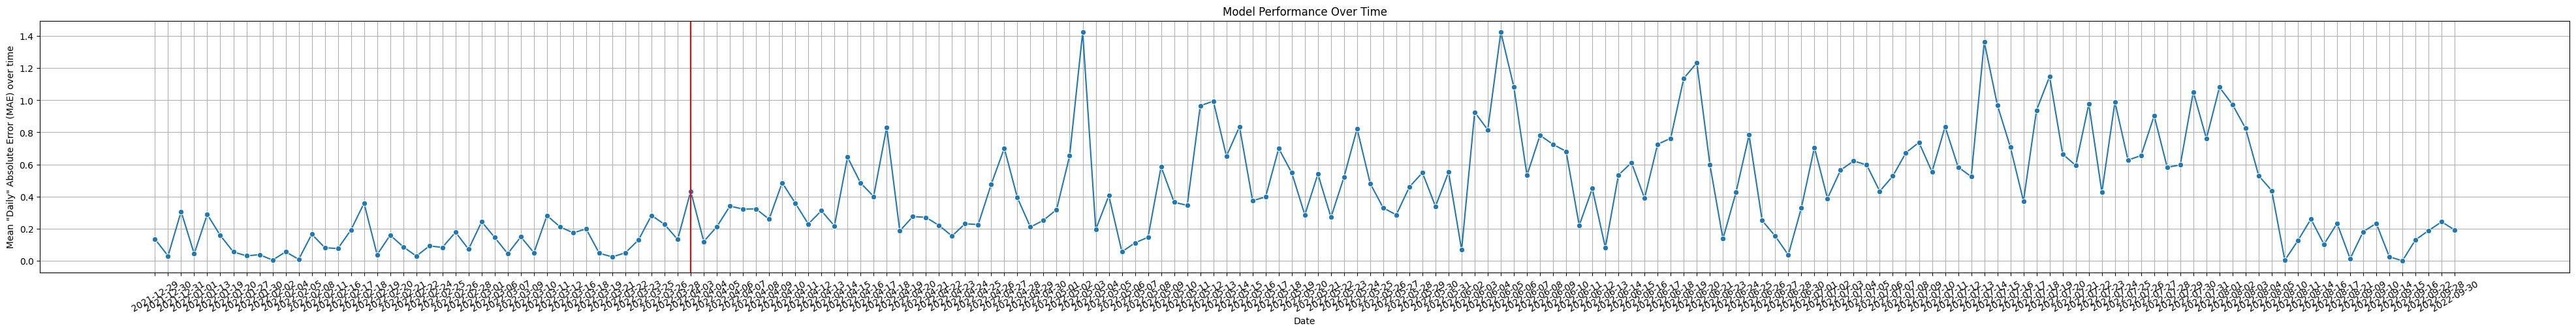

In [123]:
# It is possible to see that this model is underfitted. This usually happen when there is not enought data during training phase.

# Plot using seaborn
plt.figure(figsize=(50, 5))
sns.lineplot(x='date', y='MAE', data=daily_mae, marker='o')
plt.axvline('2022-04-03', color = 'r', linestyle = '-') 
plt.title('Model Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Mean "Daily" Absolute Error (MAE) over time')
plt.xticks(rotation=30)
# plt.tight_layout()
plt.grid(True)
plt.show()

# Final Considerations

It is evident that the IABCategory "Medical Category" and the REVCONTENT channel play a significant role in RF predictions. This should be further investigated with business experts. There are open questions that also should be addressed with business experts, such as the "0.6 bid" question.

In the performance graph, it is apparent that this baseline model is underfitted. This usually occurs when there is not enough data during training.

Results can be significantly improved if we split the training and validation data differently, using more data for training. However, we should be cautious not to use all available data, to ensure the model's stability over time.

We could also gather more data to enhance the model's performance.

Additionally, we could investigate time series relationships further and perform tests to analyze ergodicity/stability, aiming for improved model performance and stability.

If explainability is plays an important role to business strategies, we could use a Regressor Tree Model or SHAP applied to the Random Forest Regressor to generate insights from the data results.